In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
import freqcol_0_6 as fc

import msise2Netcdf as msise
import irinetcdf_02 as iri
import pyigrf_clara_0_6 as igrf

import conductivity0_9_5 as cond

#### Relative Parameter

In [3]:
def calc_pRelativa(rhoi,ne):
    """
    Calcula a densidade numérica relativa da espécie ionica. Brekke (1993).
    
    Parameters
    ----------
    rhoi : PANDA SERIES FLOAT
        densidade do íon [m^-3]     
    ne : PANDA SERIES FLOAT
        Densidade de elétrons [elétrons/m^3]
    
    Returns:
    ----------
    pi : PANDA SERIES FLOAT
        densidade numérica relativa (Brekke,1983)
        
    """    
    pi = rhoi/ne        
    return pi


#### Hall

In [5]:
def calc_Hall(fen,fin1,fin2,wi1,wi2,we,p1,p2,ne,B,save=True,name="_"):
        """
        CALCULA A CONDUTIVIDADE DE HALL APARTIR DAS EQUAÇÕES DE Adachi et al.
        Earth, Planets and Space (2017).

        Parameters
        ----------
        fen : PANDA SERIES
            frequência de colisão dos elétrons com as partículas neutras [Hz].
        fin1 : PANDA SERIES
            frequência de colisão do íon 1 com as partículas neutras [Hz].
        fin2 : PANDA SERIES
            frequência de colisão do íon 2 com as partículas neutras [Hz].
        wi1 : PANDA SERIES
            girofrequência do íon 1 [Hz].
        wi2 : PANDA SERIES
            girofrequência do íon 2 [Hz].
        we : PANDA SERIES
            girofrequência do elétron [Hz].
        p1 : TYPE
            DESCRIPTION.
        p2 : TYPE
            DESCRIPTION.
        ne : TYPE
            densidade de elétrons em [m^-3].
        B : TYPE
            intensidade do campo magnético da Terra [T].

        Returns
        -------
        self.condH : TYPE
            DESCRIPTION.

        """         
        print("\nCalculando a Condutividade de Hall...")
        e = -1.602177e-19 #Carga do elétron [C]
        d = 0
        soma = 0
        
        a1 = wi2**2/(wi2**2 + fin2**2)
        b1 = (wi1**2)/(wi1**2 + fin1**2)
        c1 = (we**2)/(we**2 + fen**2)

        soma = c1 - (p1 * b1) - (p2 * a1)
        d = (ne * np.sqrt(e**2))/B

        CondH  = d * soma
        print("CondH type",type(CondH))
        if save:
            CondH.dropna().to_csv("Hall_Conductivity"+name+'.csv')
            print("File: "+"Hall_Conductivity"+name+"saved")
            
        print("Done")
        #return soma
        return CondH

#### Pedersen

In [7]:
def calc_Pedersen(fen,fin1,fin2,wi1,wi2,we,p1,p2,ne,B):
        """
        CALCULA A CONDUTIVIDADE DE PEDERSEN APARTIR DAS EQUAÇÕES DE Adachi et al.
        Earth, Planets and Space (2017).

        Parameters
        ----------
        fen : PANDA SERIES
            frequência de colisão dos elétrons com as partículas neutras [Hz].
        fin1 : PANDA SERIES
            frequência de colisão do íon 1 com as partículas neutras [Hz].
        fin2 : PANDA SERIES
            frequência de colisão do íon O+ com as partículas neutras [Hz].
        wi1 : PANDA SERIES
            girofrequencia do íon 1 [Hz].
        wi2 : TYPE
            girofrequência do íon O+ [Hz].
        we : TYPE
            DESCRIPTION.
        p1 : TYPE
            DESCRIPTION.
        p2 : TYPE
            DESCRIPTION.
        ne : TYPE
            DESCRIPTION.
        B : TYPE
            DESCRIPTION.

        Returns
        -------
        self.CondP : TYPE
            DESCRIPTION.

        """
        e = -1.602177e-19 #Carga do elétron [C]
        d = 0
        soma = 0
        
        print("===== Calculando a condutividade de Pedersen =====")
        
        a1 = (wi2 * fin2)/(wi2**2 + fin2**2)
        b1 = (wi1 * fin1)/(wi1**2 + fin1**2)
        c1 = (we * fen)/(we**2 + fen**2)
            
        soma = c1 + p1*b1 + p2*a1
        d = (ne * np.sqrt(e**2))/B
        
        CondP = d * soma
        
        print('Done')
        #return CondP
        return CondP

## Constantes

In [9]:
me = 9.109389e-31 #Massa do elétron em repouso [kg]
e = -1.602177e-19 #Carga do elétron [C]
mi1 = 5.065e-26 #Massa do íon 1 uma mistura de NO+ (75%) e O2+ (25%) (30.5 u.m.a.) [kg]
mi2 = 2.657e-26 #Massa do íon 2 (O+) [kg] (16 a.m.u)

In [10]:
time = '0 days 00:00:00'

In [11]:
#help(fc.freqcol)

## Programa começa

### Lendo dados

#### IRI

In [15]:
namefileiri = "IRI.3D.2008001.nc"
iriteste = iri.irincdf(namefileiri)

In [16]:
iriteste.iridata.data.columns.to_list()

['Ne', 'Tn', 'Ti', 'Te', 'O+', 'H+', 'He+', 'O2+', 'NO+', 'N+']

In [17]:
iriteste.iridata.munit['H+']

{'long_name': 'Atomic_Hydrogen_ion_density', 'units': '/m^3'}

#### IRI 2D

In [19]:
namefileiri = "IRI.2D.2008001.nc"
iriteste2 = iri.irincdf(namefileiri)

In [20]:
O  = iriteste.iridata.data["O+"].loc[time]
NO = iriteste.iridata.data["NO+"].loc[time]
ne = iriteste.iridata.data["Ne"].loc[time]
O2 = iriteste.iridata.data["O2+"].loc[time]

N  = iriteste.iridata.data["N+"].loc[time]
H  = iriteste.iridata.data["H+"].loc[time]
He = iriteste.iridata.data["He+"].loc[time]

In [21]:
#O.loc[140,-50]/ne.loc[140,-50]

In [22]:
iriteste.iridata.munit

{'Ne': {'long_name': 'Electron_density', 'units': '/m**3'},
 'Tn': {'long_name': 'Neutral_Temperature', 'units': 'K'},
 'Ti': {'long_name': 'Ion_Temperature', 'units': 'K'},
 'Te': {'long_name': 'Electron_Temperature', 'units': 'K'},
 'O+': {'long_name': 'Atomic_Oxygen_ion_density', 'units': '/m^3'},
 'H+': {'long_name': 'Atomic_Hydrogen_ion_density', 'units': '/m^3'},
 'He+': {'long_name': 'Atomic_Helium_ion_density', 'units': '/m^3'},
 'O2+': {'long_name': 'Molecular_Oxygen_ion_density', 'units': '/m^3'},
 'NO+': {'long_name': 'Nitric_Oxide_ion_density', 'units': '/m^3'},
 'N+': {'long_name': 'Atomic_Nitrogen_ion_density', 'units': '/m^3'}}

In [23]:
iriteste2.iridata.munit

{'TEC': {'long_name': 'TEC', 'units': 'TECU'},
 'NmF2': {'long_name': 'NmF2', 'units': '/m^3'},
 'HmF2': {'long_name': 'HmF2', 'units': 'km'}}

In [24]:
#O.index.unique('lon')
O.index.get_level_values('lon').unique()

Index([  0.0,   5.0,  10.0,  15.0,  20.0,  25.0,  30.0,  35.0,  40.0,  45.0,
        50.0,  55.0,  60.0,  65.0,  70.0,  75.0,  80.0,  85.0,  90.0,  95.0,
       100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0, 135.0, 140.0, 145.0,
       150.0, 155.0, 160.0, 165.0, 170.0, 175.0, 180.0, 185.0, 190.0, 195.0,
       200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0,
       250.0, 255.0, 260.0, 265.0, 270.0, 275.0, 280.0, 285.0, 290.0, 295.0,
       300.0, 305.0, 310.0, 315.0, 320.0, 325.0, 330.0, 335.0, 340.0, 345.0,
       350.0, 355.0, 360.0],
      dtype='float32', name='lon')

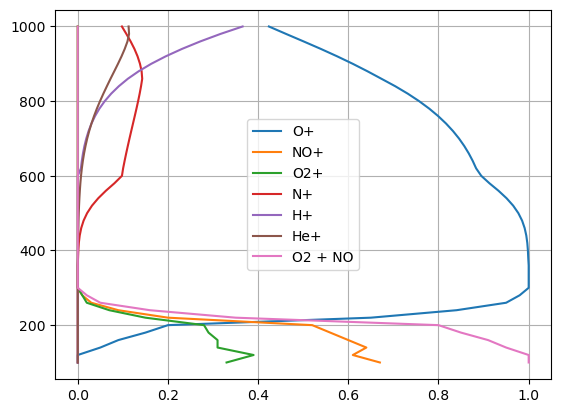

In [25]:
#O.loc[:,-50,60]/ne.loc[:,-50,60],NO.loc[:,-50,60]/ne.loc[:,-50,60],O2.loc[:,-50,60]/ne.loc[:,-50,60]

#composição da atmosfera
lon1=150
plt.plot(O.loc[:,-50,lon1]/ne.loc[:,-50,lon1],O.index.get_level_values('ht').unique(),label='O+')
plt.plot(NO.loc[:,-50,lon1]/ne.loc[:,-50,lon1],NO.index.get_level_values('ht').unique(),label='NO+')
plt.plot(O2.loc[:,-50,lon1]/ne.loc[:,-50,lon1],O2.index.get_level_values('ht').unique(),label='O2+')
plt.plot(N.loc[:,-50,lon1]/ne.loc[:,-50,lon1],O2.index.get_level_values('ht').unique(),label='N+')

plt.plot(H.loc[:,-50,lon1]/ne.loc[:,-50,lon1],H.index.get_level_values('ht').unique(),label='H+')
plt.plot(He.loc[:,-50,lon1]/ne.loc[:,-50,lon1],He.index.get_level_values('ht').unique(),label='He+')

plt.plot((O2.loc[:,-50,lon1] + NO.loc[:,-50,lon1])/ne.loc[:,-50,lon1], O2.index.get_level_values('ht').unique(), label='O2 + NO')

plt.legend()
plt.grid()

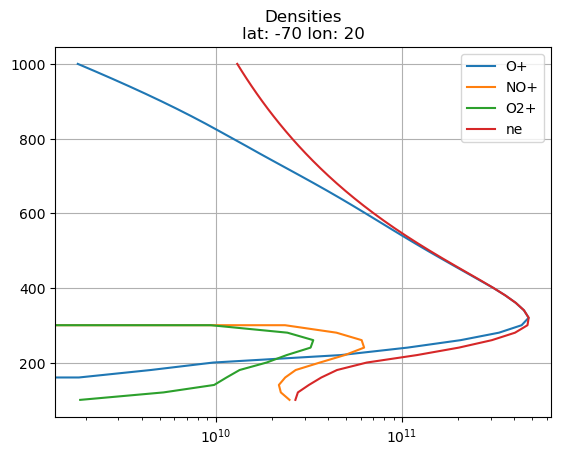

In [26]:
#O.loc[:,-50,60]/ne.loc[:,-50,60],NO.loc[:,-50,60]/ne.loc[:,-50,60],O2.loc[:,-50,60]/ne.loc[:,-50,60]

#composição da atmosfera
lon1 = 20
lat1 = -70
plt.title("Densities\nlat: "+str(lat1)+" lon: "+str(lon1))
plt.semilogx(O.loc[:,lat1,lon1],O.index.get_level_values('ht').unique(),label='O+')
plt.plot(NO.loc[:,lat1,lon1],NO.index.get_level_values('ht').unique(),label='NO+')
plt.plot(O2.loc[:,lat1,lon1],O2.index.get_level_values('ht').unique(),label='O2+')
#plt.plot(N.loc[:,lat1,lon1],O2.index.get_level_values('ht').unique(),label='N+')

#plt.plot(H.loc[:,lat1,lon1],H.index.get_level_values('ht').unique(),label='H+')
#plt.plot(He.loc[:,lat1,lon1],He.index.get_level_values('ht').unique(),label='He+')

#plt.plot((O2.loc[:,lat1,lon1] + NO.loc[:,lat1,lon1]), O2.index.get_level_values('ht').unique(), label='O2 + NO')
plt.plot(ne.loc[:,lat1,lon1],ne.index.get_level_values('ht').unique(),label='ne')

plt.legend()
plt.grid()

#### IGRF

In [28]:
#resIGRF = "igrf2008_global" #result from a previous run of pyigrf
resIGRF = "teste2024"
dado = igrf.IGRF(-80,-180,100,2008,resIGRF + '_2') #preciso garantir que estão nas mesmas coordenadas

#calcigrf = dado.calc_grid(intervalo_h = 20, lim_h = 500, intervalo_lat=10, lim_lat=90, intervalo_lon=20, lim_lon=180)
calcigrf = dado.get_grid(resIGRF + '_2' + "_grid.csv")

# print(calcigrf["B(T)"],
#       calcigrf["Altitude"],
#       calcigrf["Latitude"],
#       calcigrf["Longitude"])

dado.Dfgrid['Longitude'] = 180 + dado.Dfgrid['Longitude'] #so it will be from 0 to 360 instead
dado.Dfgrid = dado.going_to_multiindex(dado.Dfgrid)
dado.Dfgrid.index.names = ['ht','lat','lon'] #putting the same index names as the rest of the data to allow join operations

print("\nFeito\n"),calcigrf


Feito



(None,
       Unnamed: 0  Altitude  Latitude  Longitude    Year  Declination  \
 0              0     100.0     -80.0        0.0  2008.0   130.650016   
 20            20     100.0     -80.0       20.0  2008.0   106.832854   
 40            40     100.0     -80.0       40.0  2008.0    87.026928   
 60            60     100.0     -80.0       60.0  2008.0    69.730176   
 80            80     100.0     -80.0       80.0  2008.0    53.741100   
 ...          ...       ...       ...        ...     ...          ...   
 6039        6039     480.0      80.0      260.0  2008.0    26.928769   
 6059        6059     480.0      80.0      280.0  2008.0    17.599779   
 6079        6079     480.0      80.0      300.0  2008.0     2.255246   
 6099        6099     480.0      80.0      320.0  2008.0    -3.066547   
 6119        6119     480.0      80.0      340.0  2008.0     1.817205   
 
       Inclination  Horizontal_intensity  Total_intensity  North_component  \
 0      -78.987166          11153.322

#### Msise

In [30]:
filenamemsise2 = "NRLMSIS2.0.3D.2008001.nc"
msisetest = msise.nrlmsisenetcdf(filenamemsise2)

In [31]:
msisetest.msise.data

O            N2            O2  \
time            ht    lat   lon                                               
0 days 00:00:00 0.0   -90.0 0.0    9.999000e-32  1.210602e+25  3.246318e+24   
                            20.0   9.999000e-32  1.210602e+25  3.246318e+24   
                            40.0   9.999000e-32  1.210602e+25  3.246318e+24   
                            60.0   9.999000e-32  1.210602e+25  3.246318e+24   
                            80.0   9.999000e-32  1.210602e+25  3.246318e+24   
...                                         ...           ...           ...   
0 days 23:45:00 500.0  90.0 280.0  1.001533e+12  1.627130e+09  2.226342e+07   
                            300.0  1.001533e+12  1.627130e+09  2.226342e+07   
                            320.0  1.001533e+12  1.627130e+09  2.226342e+07   
                            340.0  1.001533e+12  1.627130e+09  2.226342e+07   
                            360.0  1.001533e+12  1.627130e+09  2.226342e+07   

                                           MASS          NT          ET  \
time            ht    lat   lon                                           
0 days 00:00:00 0.0   -90.0 0.0    7.452317e+02  235.886612  884.880249   
                            20.0   7.452317e+02  235.886612  884.880249   
                            40.0   7.452317e+02  235.886612  884.880249   
                            60.0   7.452317e+02  235.886612  884.880249   
                            80.0   7.452317e+02  235.886612  884.880249   
...                                         ...         ...         ...   
0 days 23:45:00 500.0  90.0 280.0  5.771498e-11  662.652161  662.652161   
                            300.0  5.771498e-11  662.652161  662.652161   
                            320.0  5.771498e-11  662.652161  662.652161   
                            340.0  5.771498e-11  662.652161  662.652161   
                            360.0  5.771498e-11  662.652161  662.652161   

                                             He            AR            AO  \
time            ht    lat   lon                                               
0 days 00:00:00 0.0   -90.0 0.0    8.061927e+19  1.446806e+23  9.999000e-32   
                            20.0   8.061927e+19  1.446806e+23  9.999000e-32   
                            40.0   8.061927e+19  1.446806e+23  9.999000e-32   
                            60.0   8.061927e+19  1.446806e+23  9.999000e-32   
                            80.0   8.061927e+19  1.446806e+23  9.999000e-32   
...                                         ...           ...           ...   
0 days 23:45:00 500.0  90.0 280.0  4.539662e+12  3.420119e+03  2.482889e+09   
                            300.0  4.539662e+12  3.420119e+03  2.482889e+09   
                            320.0  4.539662e+12  3.420119e+03  2.482889e+09   
                            340.0  4.539662e+12  3.420119e+03  2.482889e+09   
                            360.0  4.539662e+12  3.420119e+03  2.482889e+09   

                                              H             N  
time            ht    lat   lon                                
0 days 00:00:00 0.0   -90.0 0.0    9.999000e-32  9.999000e-32  
                            20.0   9.999000e-32  9.999000e-32  
                            40.0   9.999000e-32  9.999000e-32  
                            60.0   9.999000e-32  9.999000e-32  
                            80.0   9.999000e-32  9.999000e-32  
...                                         ...           ...  
0 days 23:45:00 500.0  90.0 280.0  3.050579e+11  1.307304e+10  
                            300.0  3.050579e+11  1.307304e+10  
                            320.0  3.050579e+11  1.307304e+10  
                            340.0  3.050579e+11  1.307304e+10  
                            360.0  3.050579e+11  1.307304e+10  

[6816288 rows x 11 columns]

In [32]:
msisetest.msise.munit

{'O': {'long_name': 'O_Number_Density', 'units': 'CM-3 * 1e6'},
 'N2': {'long_name': 'N2_Number_Density', 'units': 'CM-3 * 1e6'},
 'O2': {'long_name': 'O2_Number_Density', 'units': 'CM-3 * 1e6'},
 'MASS': {'long_name': 'Total_Mass_Density', 'units': 'GM/CM3 * 1e6'},
 'NT': {'long_name': 'Temperature_at_Alt', 'units': 'K'},
 'ET': {'long_name': 'Exospheric_Temperature', 'units': 'K'},
 'He': {'long_name': 'He_Number_Density', 'units': 'CM-3 * 1e6'},
 'AR': {'long_name': 'Ar_Number_Density', 'units': 'CM-3 * 1e6'},
 'AO': {'long_name': 'Anomalous_Oxygen_Number_Density', 'units': 'CM-3 * 1e6'},
 'H': {'long_name': 'H_Number_Density', 'units': 'CM-3 * 1e6'},
 'N': {'long_name': 'N_Number_Density', 'units': 'CM-3 * 1e6'}}

In [33]:
#msisetest.msise['O'].data.loc[time,:,-50,60]
#msisetest.msise['NO'].data.loc['0 days 00:00:00',:,-50,60]

## Starting Calculations

### Calculando frequencia de colisão

In [36]:
freqc = fc.freqcol(msisetest.msise.data["N2"].loc[time],
            msisetest.msise.data["O2"].loc[time],
            msisetest.msise.data["O"].loc[time],
            iriteste.iridata.data['Te'].loc[time],
            iriteste.iridata.data['Tn'].loc[time],
            iriteste.iridata.data['Ti'].loc[time])


Calculating Collision Frequency...
Done


freqc.resul.dropna()

### Calculating relative contruibution parammeter

In [39]:
#- conductivity module
parelO = calc_pRelativa(iriteste.iridata.data["O+"], iriteste.iridata.data["Ne"])
parel1 = calc_pRelativa((iriteste.iridata.data["NO+"] + iriteste.iridata.data["O2+"])/2, iriteste.iridata.data["Ne"])

In [40]:
parelO,parel1

(time             ht      lat    lon  
 0 days 00:00:00  100.0   -90.0  0.0      0.000000
                                 5.0      0.000000
                                 10.0     0.000000
                                 15.0     0.000000
                                 20.0     0.000000
                                            ...   
 0 days 23:45:00  1000.0   90.0  340.0    0.086636
                                 345.0    0.086636
                                 350.0    0.086636
                                 355.0    0.086636
                                 360.0    0.086636
 Length: 11927616, dtype: float32,
 time             ht      lat    lon  
 0 days 00:00:00  100.0   -90.0  0.0      0.5
                                 5.0      0.5
                                 10.0     0.5
                                 15.0     0.5
                                 20.0     0.5
                                         ... 
 0 days 23:45:00  1000.0   90.0  340.0    0.0
    

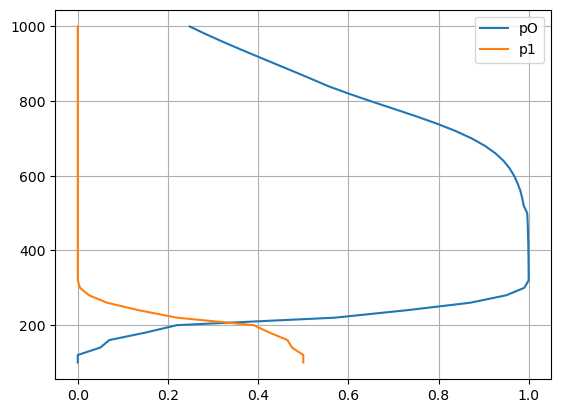

In [41]:
plt.plot(parelO.loc[time,:,-80,80],parelO.index.get_level_values('ht').unique(),label='pO')
plt.plot(parel1.loc[time,:,-80,80],parel1.index.get_level_values('ht').unique(),label='p1')
plt.legend()
plt.grid()

### Calculationg Gyrofrequency

In [43]:
gyrofreq = cond.gyrofrequency(dado.Dfgrid["B(T)"])
gyrofreq.result.index.names = ['ht','lat',"lon"] #renaming index levels

calculando as freqcol all: start 
Done


In [44]:
gyrofreq.result

we         wi1         wi2
ht    lat   lon                                        
100.0 -80.0 0.0    1.026896e+07  184.686988  352.066087
            20.0   1.005710e+07  180.876687  344.802566
            40.0   9.754655e+06  175.437217  334.433385
            60.0   9.388836e+06  168.857966  321.891455
            80.0   8.992655e+06  161.732656  308.308583
...                         ...         ...         ...
480.0  80.0 260.0  8.273699e+06  148.802251  283.659542
            280.0  8.341833e+06  150.027639  285.995481
            300.0  8.360026e+06  150.354847  286.619232
            320.0  8.336816e+06  149.937420  285.823498
            340.0  8.297310e+06  149.226893  284.469029

[6120 rows x 3 columns]

In [45]:
#juntamos num df pra facilitar os cálculos 

calcvaluesdf = gyrofreq.result.join(freqc.result.copy(),
                          how = 'inner') #inner para ficarem só as coordenadas que ambos dataframes tem

# gyrfq.sort_values(["ht",'lat','lon'],inplace=True)
# gyrfq.set_index(["ht",'lat','lon'],inplace=True)
#gyrfq.dropna()
calcvaluesdf

we         wi1         wi2           fen  \
ht    lat   lon                                                         
100.0 -80.0 0.0    1.026896e+07  184.686988  352.066087  10630.684385   
            20.0   1.005710e+07  180.876687  344.802566  10559.525982   
            40.0   9.754655e+06  175.437217  334.433385  10420.842661   
            60.0   9.388836e+06  168.857966  321.891455  10243.168612   
            80.0   8.992655e+06  161.732656  308.308583  10078.598529   
...                         ...         ...         ...           ...   
480.0  80.0 260.0  8.273699e+06  148.802251  283.659542      0.000263   
            280.0  8.341833e+06  150.027639  285.995481      0.000251   
            300.0  8.360026e+06  150.354847  286.619232      0.000160   
            320.0  8.336816e+06  149.937420  285.823498      0.000153   
            340.0  8.297310e+06  149.226893  284.469029      0.000146   

                          fin1         fin2  
ht    lat   lon                              
100.0 -80.0 0.0    1153.247628  1830.061778  
            20.0   1141.931286  1812.141731  
            40.0   1130.313404  1793.666875  
            60.0   1119.370611  1776.215782  
            80.0   1110.524800  1762.089966  
...                        ...          ...  
480.0  80.0 260.0     0.000481     0.001553  
            280.0     0.000462     0.001471  
            300.0     0.000441     0.001403  
            320.0     0.000424     0.001353  
            340.0     0.000409     0.001309  

[6120 rows x 6 columns]

### Calculando as condutividades

In [47]:
conductivity = cond.condiono_adachi()

In [48]:
p1,pO = conductivity.calc_prelativa_all(iriteste.iridata.data["O+"].loc[time],
                        iriteste.iridata.data["NO+"].loc[time],
                        iriteste.iridata.data["O2+"].loc[time],
                        iriteste.iridata.data["Ne"].loc[time])

Calculating relative contribution parameters...
Done


In [49]:
1.602177e-19*(iriteste.iridata.data["Ne"].loc[time]/dado.Dfgrid["B(T)"]).dropna()



ht     lat    lon  
100.0  -80.0  0.0      0.000119
              20.0     0.000123
              40.0     0.000134
              60.0     0.000150
              80.0     0.000169
                         ...   
480.0   80.0  260.0    0.000304
              280.0    0.000285
              300.0    0.000274
              320.0    0.000273
              340.0    0.000276
Length: 6120, dtype: float64

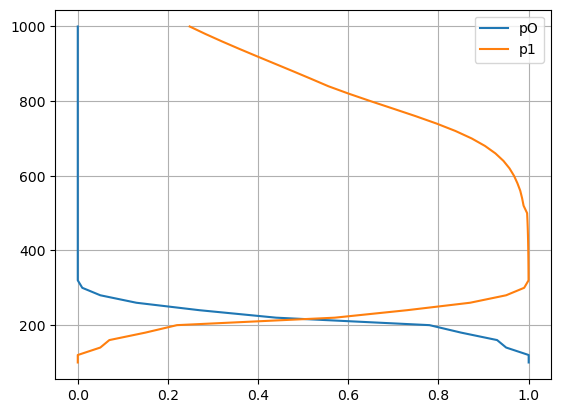

In [50]:
plt.plot(pO.loc[:,-80,80],pO.index.get_level_values('ht').unique(),label='pO')
plt.plot(p1.loc[:,-80,80],p1.index.get_level_values('ht').unique(),label='p1')
plt.legend()
plt.grid()

#### Alinging Data

In [52]:
#Alining Data by putting everything in a same Data Frame
conductivity.calcvaluesdf = gyrofreq.result.join(freqc.result.copy(),
                          how = 'inner') #inner para ficarem só as coordenadas que ambos dataframes tem

#= Ordering multiindex
conductivity.calcvaluesdf 

we         wi1         wi2           fen  \
ht    lat   lon                                                         
100.0 -80.0 0.0    1.026896e+07  184.686988  352.066087  10630.684385   
            20.0   1.005710e+07  180.876687  344.802566  10559.525982   
            40.0   9.754655e+06  175.437217  334.433385  10420.842661   
            60.0   9.388836e+06  168.857966  321.891455  10243.168612   
            80.0   8.992655e+06  161.732656  308.308583  10078.598529   
...                         ...         ...         ...           ...   
480.0  80.0 260.0  8.273699e+06  148.802251  283.659542      0.000263   
            280.0  8.341833e+06  150.027639  285.995481      0.000251   
            300.0  8.360026e+06  150.354847  286.619232      0.000160   
            320.0  8.336816e+06  149.937420  285.823498      0.000153   
            340.0  8.297310e+06  149.226893  284.469029      0.000146   

                          fin1         fin2  
ht    lat   lon                              
100.0 -80.0 0.0    1153.247628  1830.061778  
            20.0   1141.931286  1812.141731  
            40.0   1130.313404  1793.666875  
            60.0   1119.370611  1776.215782  
            80.0   1110.524800  1762.089966  
...                        ...          ...  
480.0  80.0 260.0     0.000481     0.001553  
            280.0     0.000462     0.001471  
            300.0     0.000441     0.001403  
            320.0     0.000424     0.001353  
            340.0     0.000409     0.001309  

[6120 rows x 6 columns]

#### Hall

In [54]:
# Hall
conductivity.calc_Hall(conductivity.calcvaluesdf["fen"],
                       conductivity.calcvaluesdf["fin1"],
                       conductivity.calcvaluesdf["fin2"], 
                       conductivity.calcvaluesdf['wi1'],
                       conductivity.calcvaluesdf['wi2'],
                       conductivity.calcvaluesdf['we'],
                       conductivity.p1,
                       conductivity.p2,
                       iriteste.iridata.data['Ne'].loc[time],
                       dado.Dfgrid["B(T)"]).dropna()


== Calculando a Condutividade de Hall
Done


ht     lat    lon  
100.0  -80.0  0.0      0.000114
              20.0     0.000119
              40.0     0.000130
              60.0     0.000145
              80.0     0.000164
                         ...   
480.0   80.0  260.0    0.000018
              280.0    0.000019
              300.0    0.000021
              320.0    0.000024
              340.0    0.000026
Length: 6120, dtype: float64

In [55]:
conductivity.CondH.rename("Hall's conductivity [S/m]")

ht      lat    lon  
100.0   -90.0  0.0     NaN
               5.0     NaN
               10.0    NaN
               15.0    NaN
               20.0    NaN
                        ..
1000.0   90.0  340.0   NaN
               345.0   NaN
               350.0   NaN
               355.0   NaN
               360.0   NaN
Name: Hall's conductivity [S/m], Length: 124246, dtype: float64

In [56]:
testehall = calc_Hall(calcvaluesdf["fen"],
                       calcvaluesdf["fin1"],
                       calcvaluesdf["fin2"], 
                       calcvaluesdf['wi1'],
                       calcvaluesdf['wi2'],
                       calcvaluesdf['we'],
                       parelO.loc[time],
                       parel1.loc[time],
                       iriteste.iridata.data['Ne'].loc[time],
                       dado.Dfgrid["B(T)"],True,"wetrqerewrt").dropna()
testehall


Calculando a Condutividade de Hall...
CondH type <class 'pandas.core.series.Series'>
File: Hall_Conductivitywetrqerewrtsaved
Done


ht     lat    lon  
100.0  -80.0  0.0      0.000116
              20.0     0.000121
              40.0     0.000132
              60.0     0.000147
              80.0     0.000166
                         ...   
480.0   80.0  260.0    0.000018
              280.0    0.000019
              300.0    0.000021
              320.0    0.000024
              340.0    0.000026
Length: 6120, dtype: float64

In [57]:
testehall.to_csv("teste_condH")

#### Pedersen

In [59]:
conductivity.calc_Pedersen(conductivity.calcvaluesdf["fen"],
                       conductivity.calcvaluesdf["fin1"],
                       conductivity.calcvaluesdf["fin2"], 
                       conductivity.calcvaluesdf['wi1'],
                       conductivity.calcvaluesdf['wi2'],
                       conductivity.calcvaluesdf['we'],
                       conductivity.p1,
                       conductivity.p2,
                       iriteste.iridata.data['Ne'].loc[time],
                       dado.Dfgrid["B(T)"]).dropna()
conductivity.CondP.rename("Pedersen's conductivity [S/m]")


== Calculando a condutividade de Pedersen
Done



ht      lat    lon  
100.0   -90.0  0.0     NaN
               5.0     NaN
               10.0    NaN
               15.0    NaN
               20.0    NaN
                        ..
1000.0   90.0  340.0   NaN
               345.0   NaN
               350.0   NaN
               355.0   NaN
               360.0   NaN
Name: Pedersen's conductivity [S/m], Length: 124246, dtype: float64

In [60]:
conductivity.calc_Pedersen(calcvaluesdf["fen"],
                       calcvaluesdf["fin1"],
                       calcvaluesdf["fin2"], 
                       calcvaluesdf['wi1'],
                       calcvaluesdf['wi2'],
                       calcvaluesdf['we'],
                       parelO.loc[time],
                       parel1.loc[time],
                       iriteste.iridata.data['Ne'].loc[time],
                       dado.Dfgrid["B(T)"]).dropna()


== Calculando a condutividade de Pedersen
Done



ht     lat    lon  
100.0  -80.0  0.0      1.112303e-05
              20.0     1.145521e-05
              40.0     1.222641e-05
              60.0     1.330271e-05
              80.0     1.450711e-05
                           ...     
480.0   80.0  260.0    9.260834e-10
              280.0    8.165424e-10
              300.0    7.411908e-10
              320.0    7.034573e-10
              340.0    6.856609e-10
Length: 6120, dtype: float64

In [61]:
testepedersen = calc_Pedersen(calcvaluesdf["fen"],
                      calcvaluesdf["fin1"],
                      calcvaluesdf["fin2"], 
                      calcvaluesdf['wi1'],
                      calcvaluesdf['wi2'],
                      calcvaluesdf['we'],
                      parelO.loc[time],
                      parel1.loc[time],
                      iriteste.iridata.data['Ne'].loc[time],
                      dado.Dfgrid["B(T)"]).dropna()
testepedersen

===== Calculando a condutividade de Pedersen =====
Done


ht     lat    lon  
100.0  -80.0  0.0      1.112303e-05
              20.0     1.145521e-05
              40.0     1.222641e-05
              60.0     1.330271e-05
              80.0     1.450711e-05
                           ...     
480.0   80.0  260.0    9.260834e-10
              280.0    8.165424e-10
              300.0    7.411908e-10
              320.0    7.034573e-10
              340.0    6.856609e-10
Length: 6120, dtype: float64

## Plotando

In [63]:
h = 200 #height to plot data in km

testepedersen_plot = testepedersen.loc[h].reset_index() #voltando pro index normal pra latitude e longitude serem colunas
testehall_plot = testehall.loc[h].reset_index()
ne_plot = ne.loc[h].reset_index()

In [64]:
#testehall_plot, testehall.loc[100].reset_index()

Text(0.5, 1.0, 'Mapa da condutividade de Hall do ano de 2008 100km de altura')

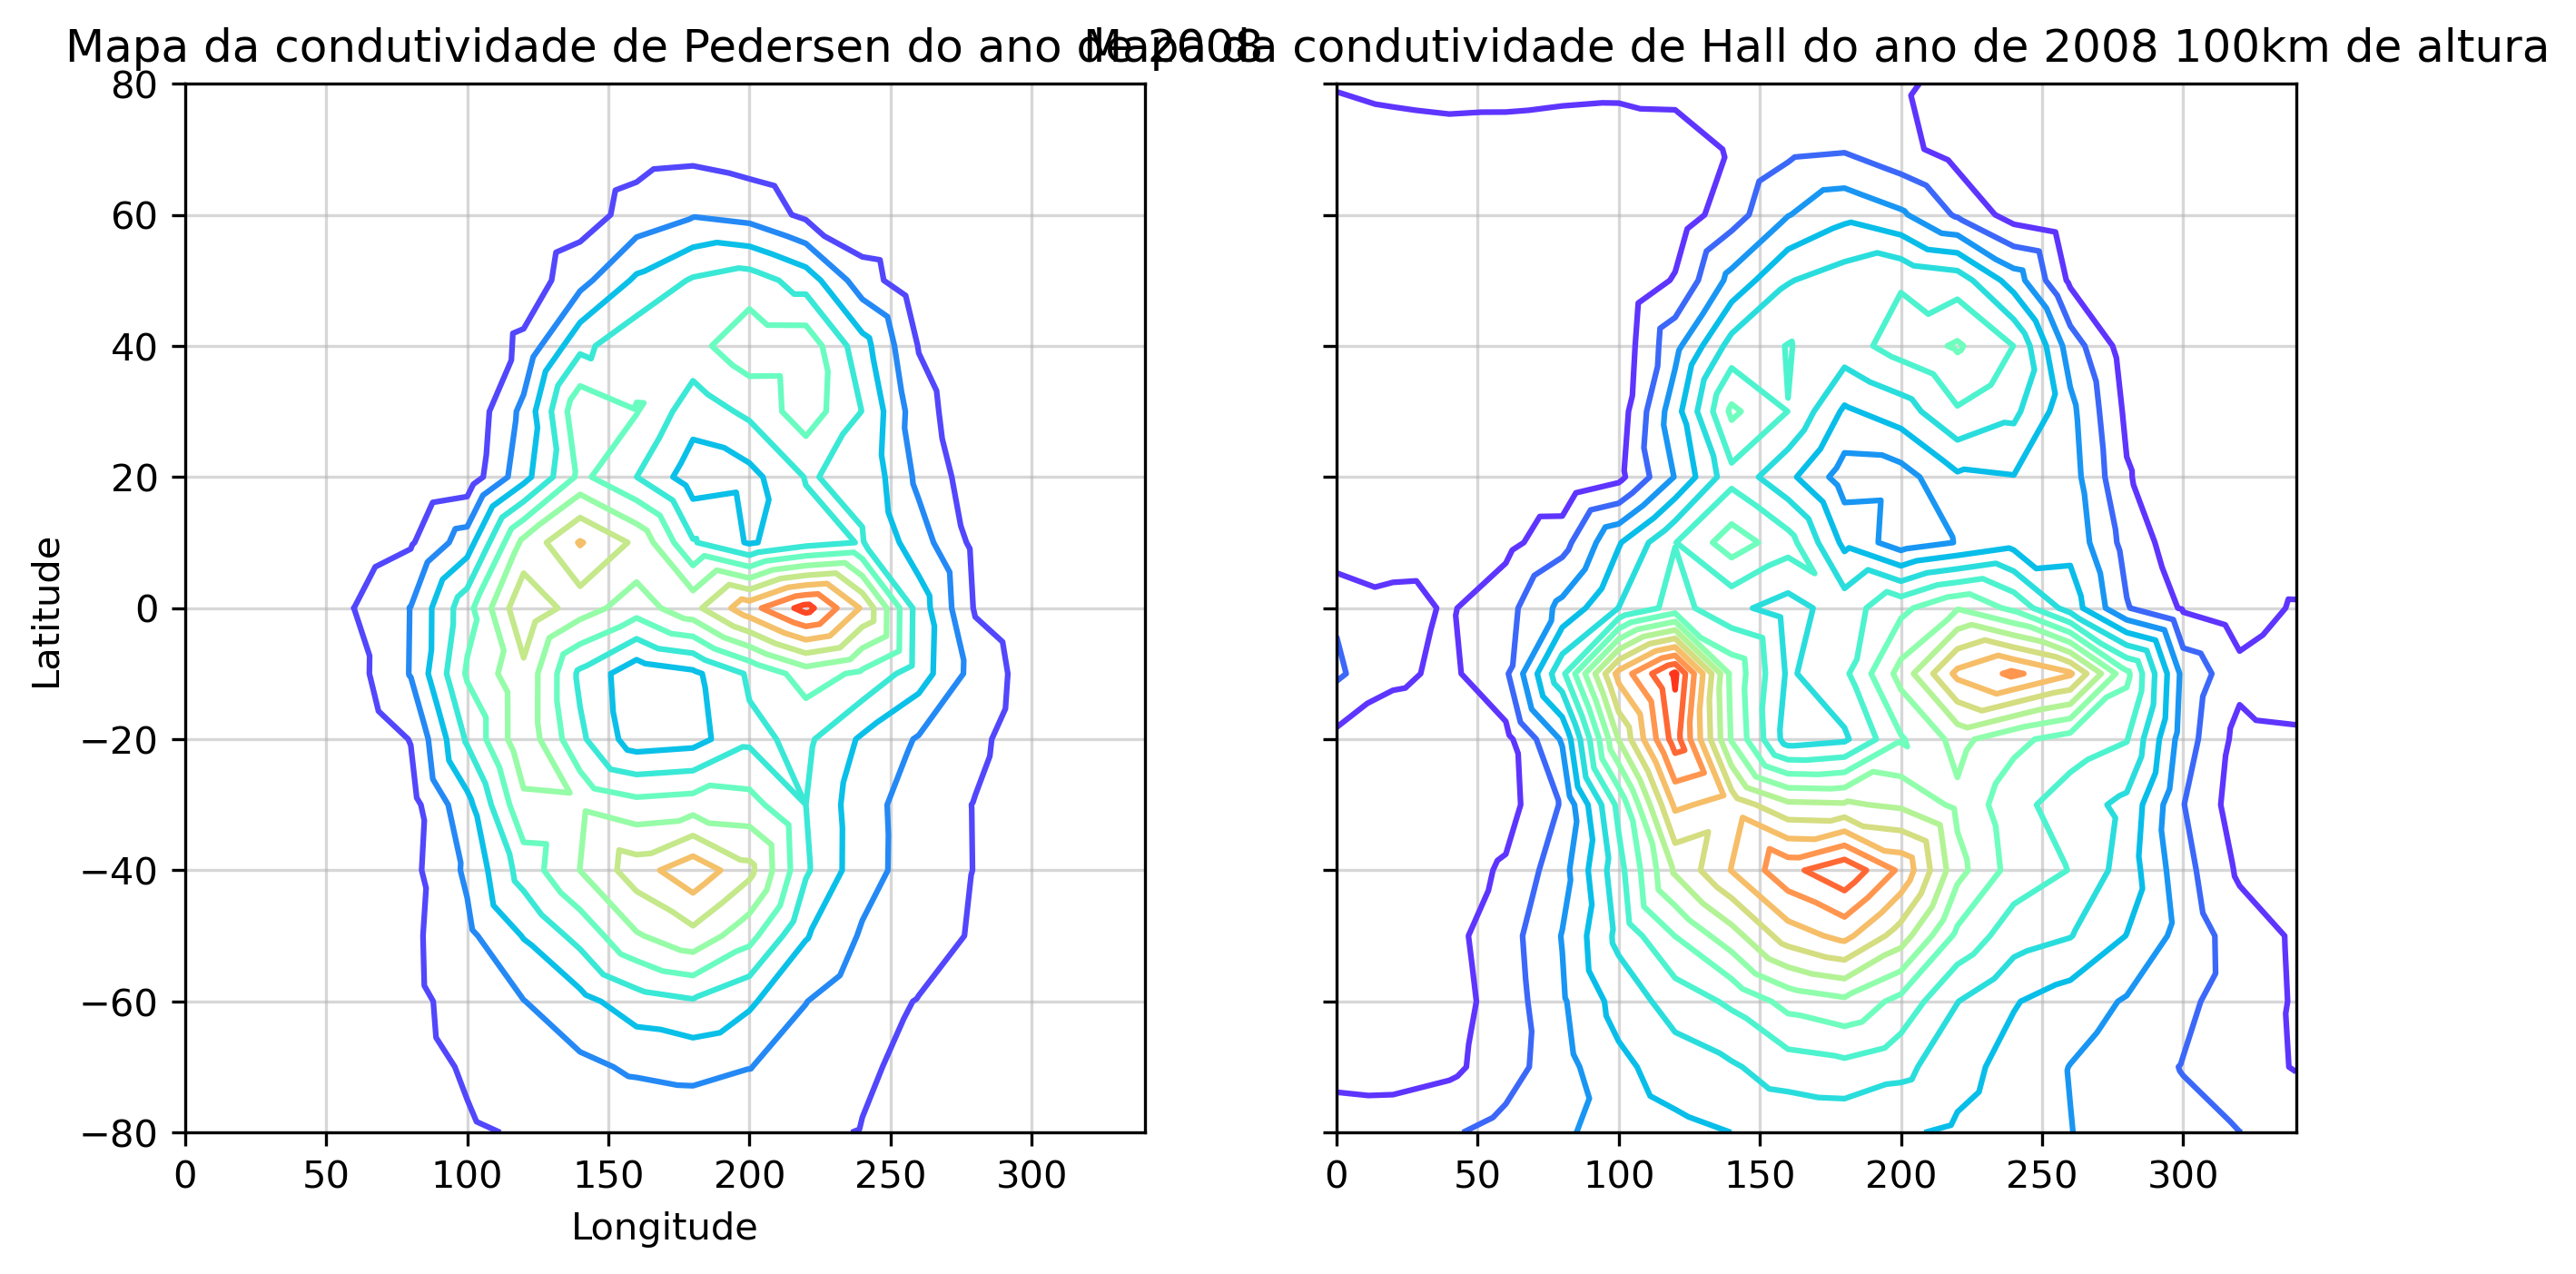

In [65]:
fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True,dpi=300)
ax[0].set_title("Mapa da condutividade de Pedersen do ano de 2008")
ax[0].set_ylabel("Latitude")
ax[0].set_xlabel("Longitude")
#ax[0].legend()
#fig.colorbar()
ax[0].grid(visible = True, alpha=0.5)
ax[0].tricontour(testepedersen_plot["lon"],testepedersen_plot["lat"],testepedersen_plot.loc[:,0],10,cmap='rainbow')

ax[1].tricontour(testehall_plot["lon"],testehall_plot["lat"],testehall_plot.loc[:,0],20,cmap='rainbow')
ax[1].grid(visible = True, alpha=0.5)
ax[1].set_title("Mapa da condutividade de Hall do ano de 2008 100km de altura")

#plt.tripcolor(testepedersen_plot["lon"],testepedersen_plot["lat"],testepedersen_plot.loc[:,0],cmap='rainbow')

### Grafico 2D

#### Criando meshgrid

In [68]:
X,Y = np.meshgrid(testehall_plot["lon"].unique()-180,testehall_plot["lat"].unique())
Xe,Ye = np.meshgrid( ne_plot['lon'].unique()-180, ne_plot['lat'].unique())

In [69]:
#X,Y,X[1,2]

In [70]:
#testehall_plot["lat"==20].to_numpy() #passing to numpy array format

#### Countour maps

#### prepplot_2dgrid

In [73]:
def prepplot_2dgrid(values,h,title=" "):
    values_plot = values.loc[h].reset_index() #leaving the multindex to use normal indexing
    
    X,Y = np.meshgrid(values_plot['lon'].unique() - 180,values_plot['lat'].unique())

    value2dformat = pd.DataFrame([])
    for i in values_plot['lon'].unique():
        value2dformat[i] = values.loc[h,:,i]
        #print('\n\n i',i,'\nvalues2dformat[i]\n',value2dformat[i],'\n\n values.loc[]',values.loc[h,:,i])
        
    return X,Y,value2dformat

In [74]:
def prepplot_valueto2Dgrid(values,h):
    value2dformat = pd.DataFrame([])
    values_plot = values.loc[h].reset_index() #leaving the multindex to use normal indexing
    
    for i in values_plot['lon'].unique():
        value2dformat[i] = values.loc[h,:,i]
        #print('\n\n i',i,'\nvalues2dformat[i]\n',value2dformat[i],'\n\n values.loc[]',values.loc[h,:,i])
    
    return value2dformat

def prepplot_create2Dmeshgrid(values,h):
    values_plot = values.loc[h].reset_index() #leaving the multindex to use normal indexing
    
    X,Y = np.meshgrid(values_plot['lon'].unique() - 180, values_plot['lat'].unique())
    
    return X,Y

In [75]:
eletricidade = pd.DataFrame([])
for i in testepedersen_plot["lon"].unique():
    #print("\nlon",i,'\n',testepedersen.loc[100,:,i])
    eletricidade[i] = testepedersen.loc[h,:,i]

eletricidade2 = pd.DataFrame([])
for i in testehall_plot["lon"].unique():
    #print("\nlat",i,testehall.loc[h,:,i])
    eletricidade2[i] = testehall.loc[h,:,i]

edensity = pd.DataFrame([])
for i in ne_plot['lon'].unique():
    edensity[i] = ne.loc[h,:,i]
#eletricidade2.set_axis(np.array([ 0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.])-180, axis=1)
#colocando os valores de da eletricidade numa matriz 2D para poder plotar
#eletricidade.rename_axis("Longitude",axis=1)

In [76]:
fen = freqc.result['fen'].dropna()
fen

ht     lat    lon  
100.0  -90.0  0.0      10120.293065
              20.0     10120.293065
              40.0     10120.293065
              60.0     10120.293065
              80.0     10120.293065
                           ...     
500.0   90.0  280.0        0.000068
              300.0        0.000068
              320.0        0.000068
              340.0        0.000068
              360.0        0.000068
Name: fen, Length: 14763, dtype: float64

#### plot_2dgrid

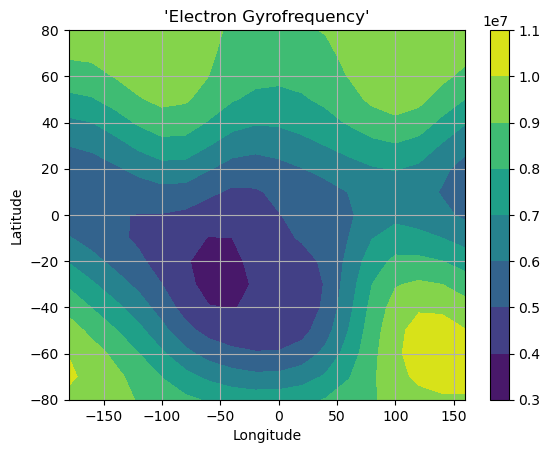

<module 'matplotlib.pyplot' from 'C:\\Users\\tedea\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [78]:
def plot_2dgrid(values,h,title=" "):
    values_plot = values.loc[h].reset_index() #leaving the multindex to use normal indexing
    
    X,Y = np.meshgrid(values_plot['lon'].unique()-180,values_plot['lat'].unique())

    value2dformat = pd.DataFrame([])
    for i in values_plot['lon'].unique():
        value2dformat[i] = values.loc[h,:,i]
        
    plt.contourf(X,Y,value2dformat)
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()
    plt.colorbar()   
    
    plt.show()
    return plt
    
plot_2dgrid(calcvaluesdf['we'],h,"'Electron Gyrofrequency'")

In [79]:
#plot_2dgrid(freqc.resul['fin1'].dropna(),h,"'Electron Gyrofrequency'")

In [80]:
freqcres_plot = freqc.result['fin1'].loc[h].reset_index()
fin = freqc.result['fin1'].dropna().reset_index()
fin

ht   lat    lon          fin1
0        0.0 -90.0    0.0  6.566674e+09
1        0.0 -90.0   20.0  6.566674e+09
2        0.0 -90.0   40.0  6.566674e+09
3        0.0 -90.0   60.0  6.566674e+09
4        0.0 -90.0   80.0  6.566674e+09
...      ...   ...    ...           ...
70998  500.0  90.0  280.0  2.420769e-04
70999  500.0  90.0  300.0  2.420769e-04
71000  500.0  90.0  320.0  2.420769e-04
71001  500.0  90.0  340.0  2.420769e-04
71002  500.0  90.0  360.0  2.420769e-04

[71003 rows x 4 columns]

In [81]:
freqc.result['fin1'].loc[h]

lat    lon  
-90.0  0.0      1.466449
       5.0           NaN
       10.0          NaN
       15.0          NaN
       20.0     1.466449
                  ...   
 90.0  340.0    1.082349
       345.0         NaN
       350.0         NaN
       355.0         NaN
       360.0    1.082349
Name: fin1, Length: 2701, dtype: float64

In [82]:
freqcres_plot = freqc.result.loc[h].dropna().reset_index()

valuefen  = pd.DataFrame([])
for i in freqcres_plot['lon'].dropna().unique():
    #print("\nlon",i,'\n',testepedersen.loc[100,:,i])
    valuefen[i] = freqc.result["fen"].loc[h,:,i]

In [83]:
Xfen,Yfen = np.meshgrid(ne_plot['lon'].unique()-180, ne_plot['lat'].unique())

#### Gyrofrequency

In [85]:
import geopandas as gpd

In [86]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

countries = gpd.read_file(url)
#countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

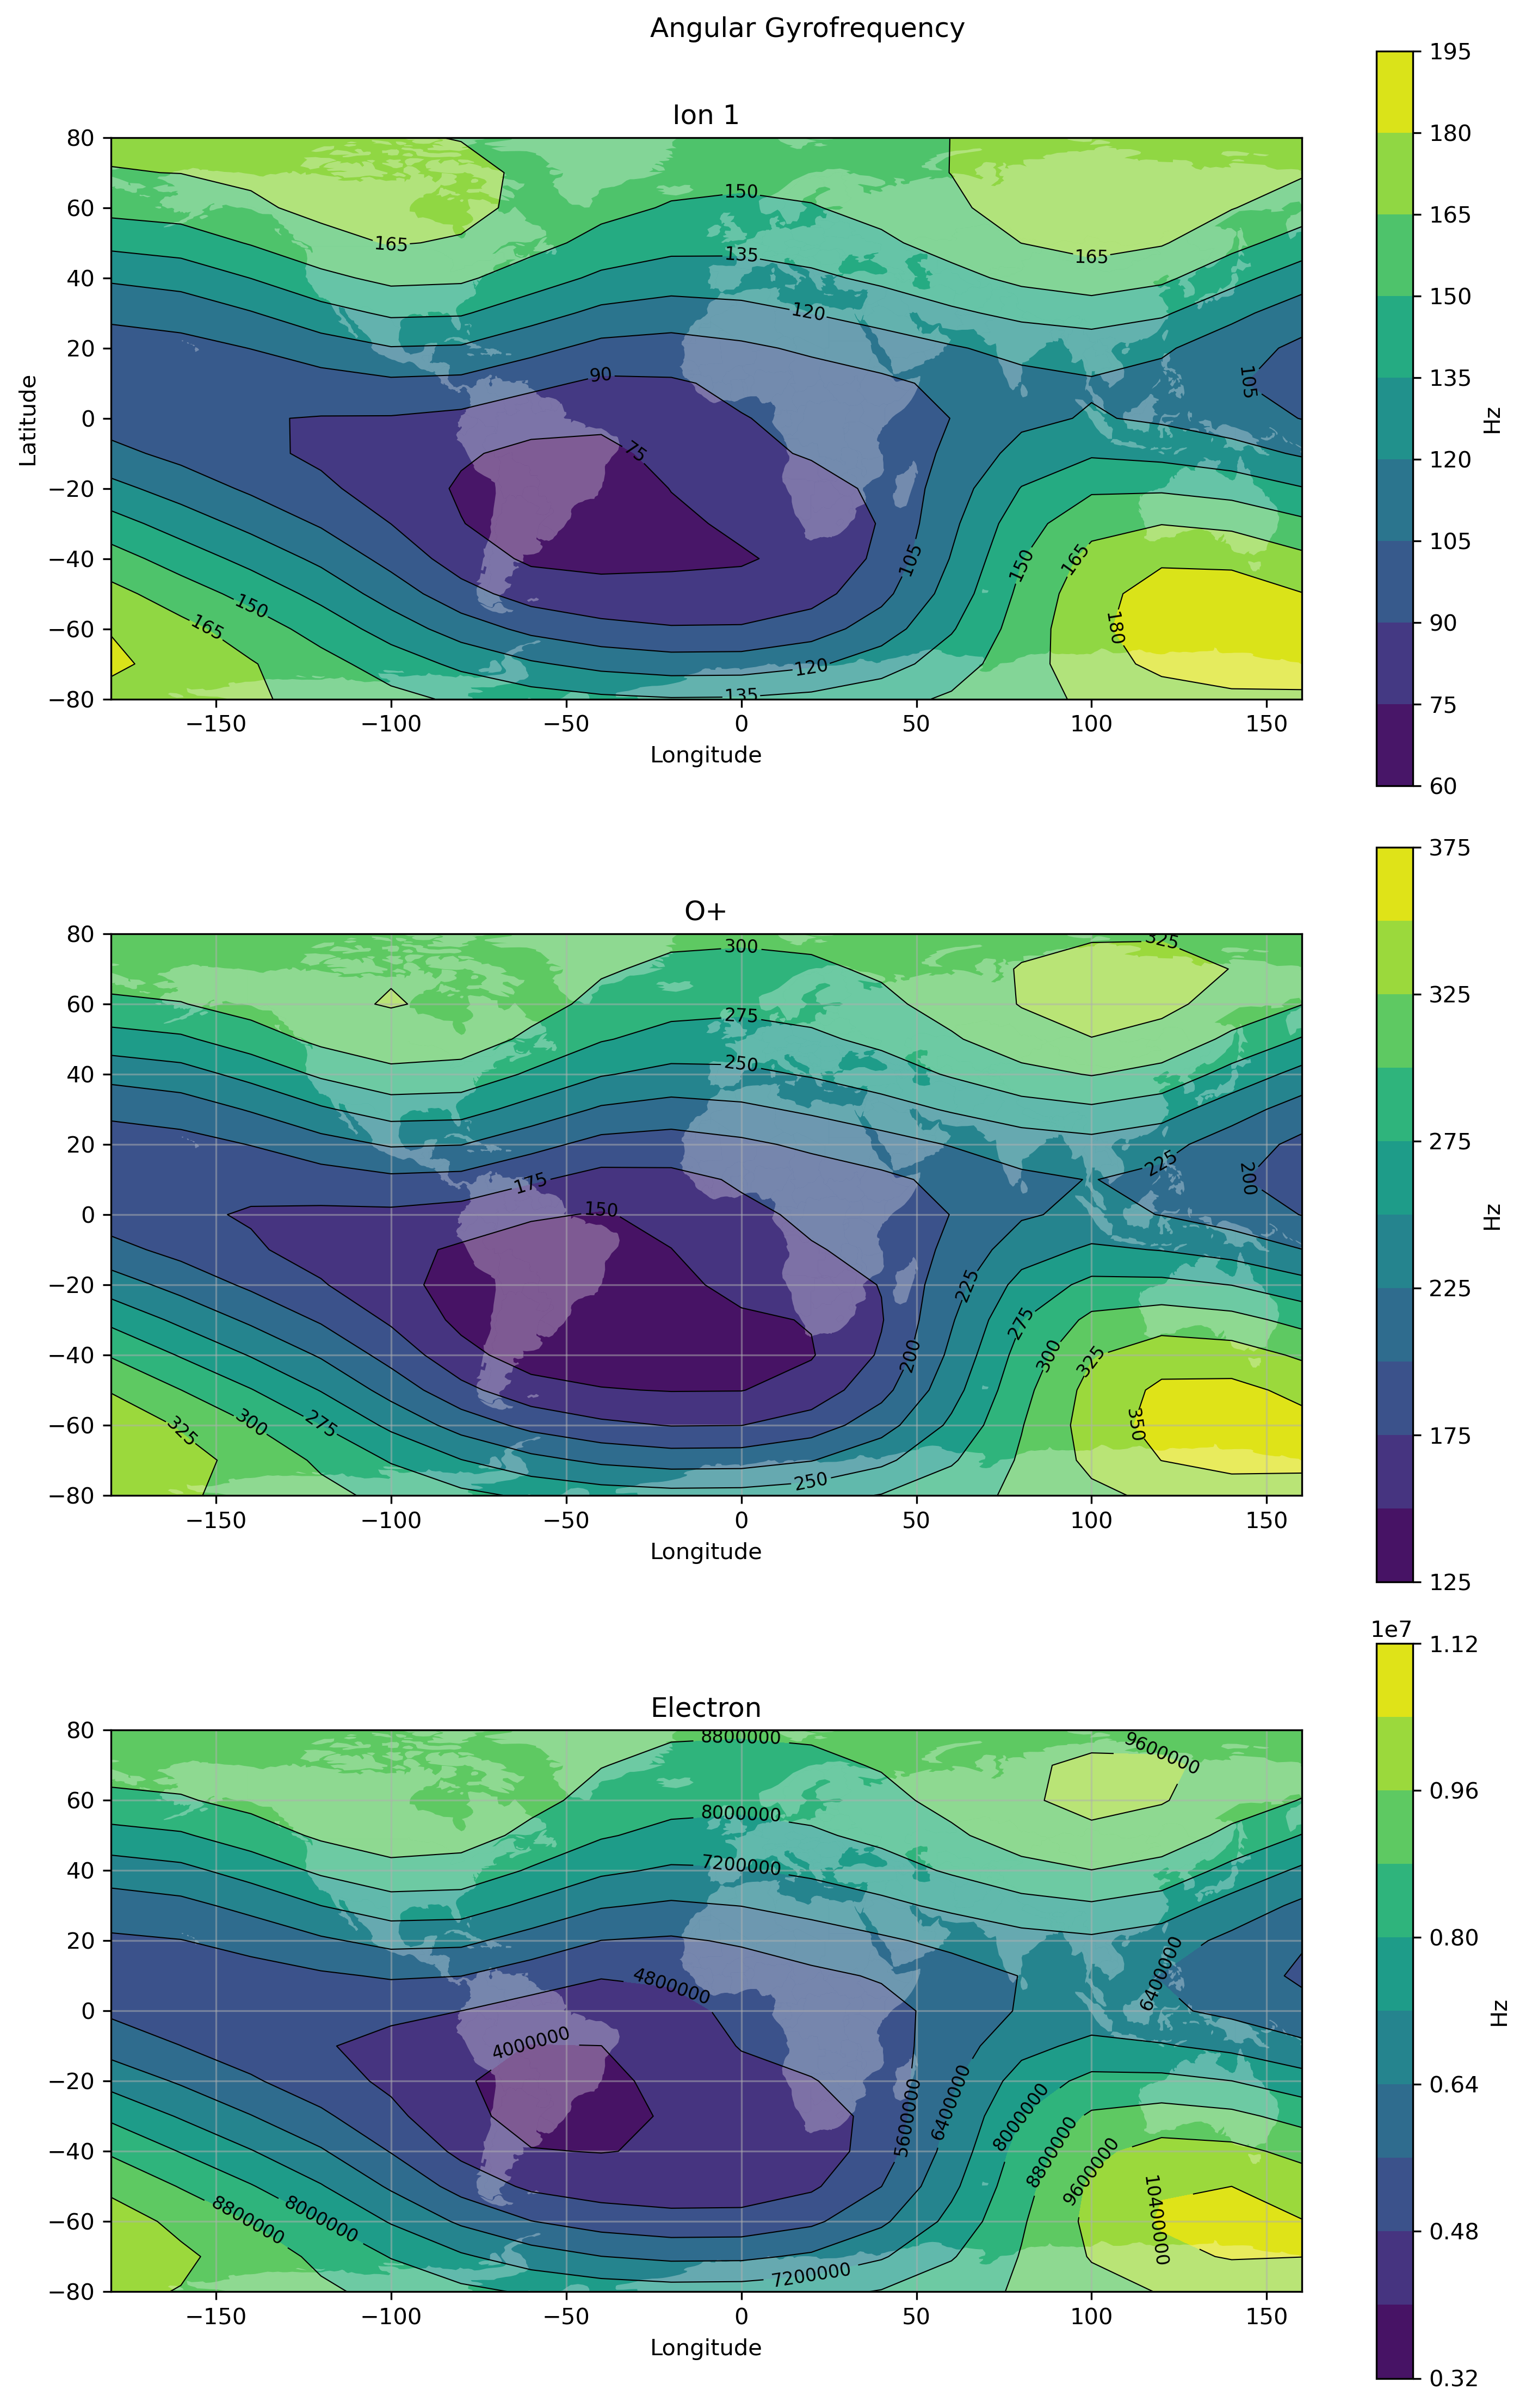

In [87]:
sizefig = (10,15)

fig,ax = plt.subplots(3,1,figsize = sizefig, dpi = 300,layout = 'tight')
fig.suptitle("Angular Gyrofrequency")
#fig.tight_layout()

Xi,Yi,values = prepplot_2dgrid(calcvaluesdf['wi1'],h,"'Ion 1'")

cntr1 = ax[0].contourf(Xi,Yi,values,levels=10)
contour1 = ax[0].contour(Xi,Yi,values,levels=10,colors='black', linewidths=0.5)
plt.clabel(contour1, inline = True, fontsize=8)

ax[0].set_title("Ion 1")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
cbar1 = fig.colorbar(cntr1, ax = ax[0], label = "Hz")
#ax[0].grid(visible = True, alpha=0.5)
countries.plot(ax = ax[0], color = "white",figsize=sizefig, alpha=0.3)
#countries.exterior.plot(ax = ax[0], color = "gray",figsize=sizefig, alpha=0.3,linewidths=0.3)
#countries.head()
ax[0].set_xlim([-180, 160])
ax[0].set_ylim([-80, 80])


X2,Y2,values2 = prepplot_2dgrid(calcvaluesdf['wi2'], h,"'O+'")

cntr2 = ax[1].contourf(X2, Y2, values2, levels = 10)
contour2 = ax[1].contour(X2, Y2, values2, levels = 10,colors='black', linewidths=0.5)
cbar2 = fig.colorbar(cntr2,ax=ax[1],label="Hz")

ax[1].clabel(contour2, inline = True, fontsize=8)
#countries["geometry"].boundary.plot(ax = ax[1], color = "yellow",figsize=sizefig, linewidths=0.3)
countries.plot(ax = ax[1], color = "white",figsize=sizefig, alpha=0.3)

ax[1].set_xlim([-180, 160])
ax[1].set_ylim([-80, 80])
ax[1].set_title('O+')
ax[1].set_xlabel("Longitude")
ax[1].grid(visible = True, alpha=0.5)


X3,Y3,values3 = prepplot_2dgrid(calcvaluesdf['we'],h,"'Electron'")

cntr3 = ax[2].contourf(X3,Y3,values3,levels = 10)
contour3 = ax[2].contour(X3,Y3,values3,levels=10,colors='black', linewidths=0.5)
cbar3 = fig.colorbar(cntr3,ax=ax[2],label="Hz")

#countries["geometry"].boundary.plot(ax = ax[2], color = "white",figsize=sizefig)
countries.plot(ax = ax[2], color = "white",figsize=sizefig, alpha=0.3)
plt.clabel(contour3, inline = True, fontsize=8)

ax[2].set_xlim([-180, 160])
ax[2].set_ylim([-80, 80])
ax[2].set_title('Electron')
ax[2].set_xlabel("Longitude")
ax[2].grid(visible = True, alpha=0.5)

#countries.head()

#fig.savefig("plot_Angular Gyrofrequency" + name_saida + '.png', dpi = 300, transparent=True)

#ax[1][0] = prepplot_2dgrid(calcvaluesdf['fen'],h,"Electron colission frequency")
#ax[1][1] = prepplot_2dgrid(calcvaluesdf['fin1'],h,"Ion1 colission frequency")
#plot_2dgrid(calcvaluesdf['fin2'],h,"Ion O colission frequency")

#### Collision Frequency

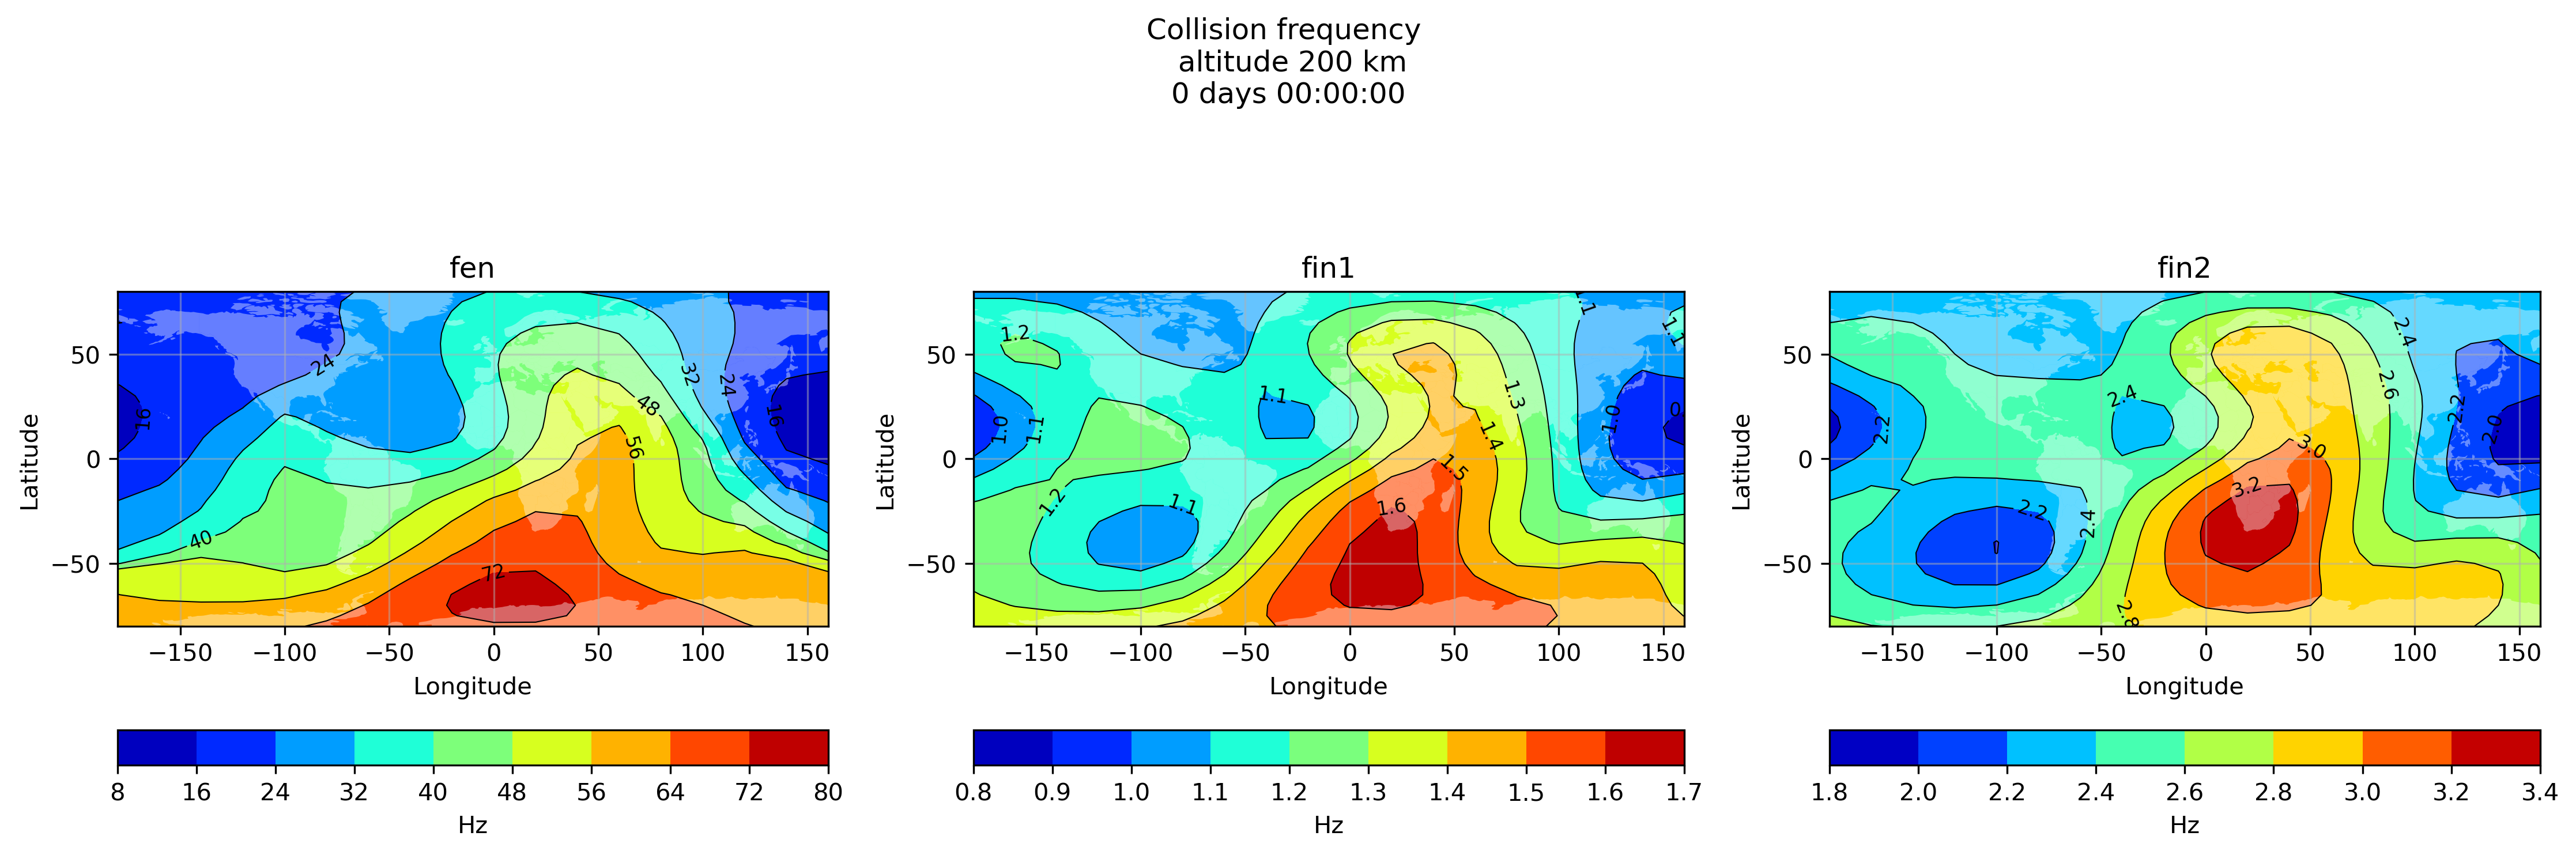

In [89]:

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig,ax = plt.subplots(1,3,figsize = (15,5),dpi=300,layout = 'tight' )
fig.suptitle("Collision frequency \n altitude " + str(h) + ' km\n' 
             + str(time))

columns = freqc.result.columns.to_list()
titles = ['Electron Colision frequency',
    "Ion 1 - neutrals Colision frequency",
          'Ion O+ Colision frequency']

for i in range(3):

    X,Y = prepplot_create2Dmeshgrid(freqc.result[columns[i]].dropna(),h)
    valfreq = prepplot_valueto2Dgrid(freqc.result[columns[i]].dropna(),h)
    
    cntr = ax[i].contourf(X,Y,valfreq,cmap='jet')
    contour = ax[i].contour(X,Y,valfreq,colors='black', linewidths=0.5)

    countries.plot(ax = ax[i], color = "white",figsize=sizefig, alpha = 0.4)
    plt.clabel(contour, inline = True, fontsize = 8)
    
    ax[i].set_title(columns[i])
    ax[i].set_xlim([-180, 160])
    ax[i].set_ylim([-80, 80])
    #ax[i].axis('equal')
    ax[i].grid(visible = True, alpha = 0.5)
    ax[i].set_xlabel("Longitude")
    ax[i].set_ylabel("Latitude")
    cbar = fig.colorbar(cntr,ax = ax[i],location = 'bottom')
    cbar.set_label("Hz")


plt.savefig("frequenciasdecolisao.png")
# X2,Y2,valfin2 = prepplot_2dgrid(freqc.resul['fin2'].dropna(),h,"'Ion O Gyrofrequency'")

# cntr2 = ax[1].contourf(X2,Y2,valfin2)
# contour1 = ax[1].contour(X2,Y2,valfin2,colors='black', linewidths=0.5)

# plt.clabel(contour1, inline=True, fontsize=8)
# cbar2 = fig.colorbar(cntr2, ax = ax[1])
# cbar2.set_label("Hz")
# ax[1].grid(visible = True, alpha=0.5)
# ax[1].set_title()
# ax[1].set_ylabel("Latitude")
# #ax[1].set_xlabel("Longitude")


# X2,Y2,valfen = prepplot_2dgrid(freqc.resul['fen'].dropna(),h)
# cntr3 = ax[2].contourf(X2, Y2, valfen)
# contour2 = ax[2].contour(X2, Y2, valfen, colors = 'black', linewidths = 0.5)

# plt.clabel(contour2, inline = True, fontsize = 8)
# cbar3 = fig.colorbar(cntr3, ax = ax[2])
# ax[2].grid(visible = True, alpha = 0.5)
# ax[2].set_title('')
# ax[2].set_xlabel("Longitude")
# ax[2].set_ylabel("Latitude")
# cbar3.set_label("Hz")

In [90]:
freqc.result.columns.to_list()

['fen', 'fin1', 'fin2']

In [91]:
#Xi,Yi,valfin1 = prepplot_2dgrid(calcvaluesdf['fin1'],h,"'Ion 1 Gyrofrequency'")

In [92]:
calcvaluesdf['wi1']

ht     lat    lon  
100.0  -80.0  0.0      184.686988
              20.0     180.876687
              40.0     175.437217
              60.0     168.857966
              80.0     161.732656
                          ...    
480.0   80.0  260.0    148.802251
              280.0    150.027639
              300.0    150.354847
              320.0    149.937420
              340.0    149.226893
Name: wi1, Length: 6120, dtype: float64

#### Densidade de Elétrons

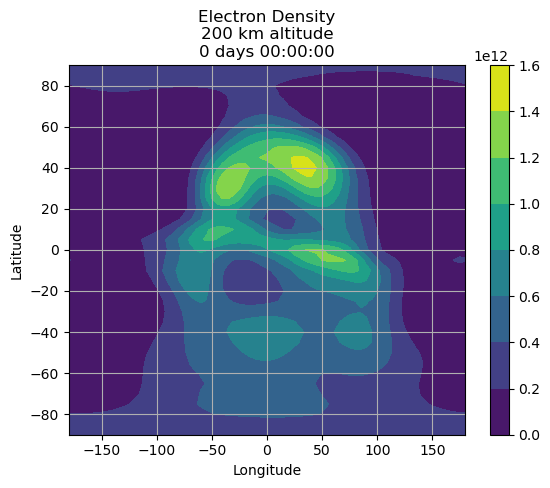

<module 'matplotlib.pyplot' from 'C:\\Users\\tedea\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [94]:
plot_2dgrid(iriteste.iridata.data["Ne"].loc[time],h,"Electron Density\n"+str(h)+" km altitude\n" + time)

X,Y,values3 = prepplot_2dgrid(calcvaluesdf['we'],h,"'Electron Gyrofrequency'")
ax[1].contourf(X,Y,values3)

#### Imagens da condutividade

In [219]:
def plot_2dgrid(values,h,title=" "):
    values_plot = values.loc[h].reset_index() #leaving the multindex to use normal indexing
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    X,Y = np.meshgrid(values_plot['lon'].unique() - 180,values_plot['lat'].unique())

    value2dformat = pd.DataFrame([])
    for i in values_plot['lon'].unique():
        value2dformat[i] = values.loc[h,:,i]

    fig, ax = plt.subplots()
    cntr = ax.contourf(X,Y,value2dformat)
    contour = ax.contour(X,Y,value2dformat,colors='black', linewidths=0.5)
    ax.clabel(contour, inline = True, fontsize = 8)

    countries.plot(ax=ax,color = "white",figsize=sizefig, alpha = 0.4)
    
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim([-180, 180])
    ax.set_ylim([-80,80])
    ax.grid(visible = True, alpha = 0.5)
    
    fig.colorbar(cntr, ax=ax, label='conductivity',location = 'bottom')

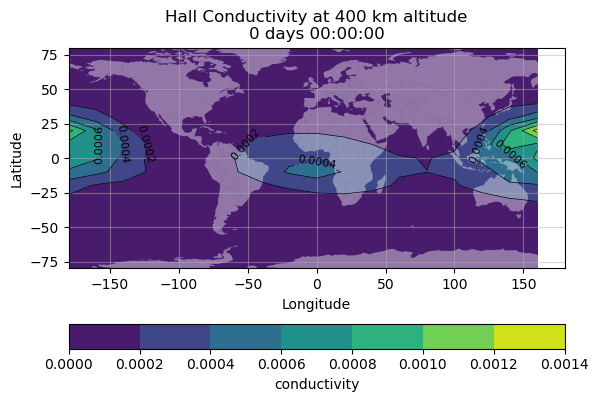

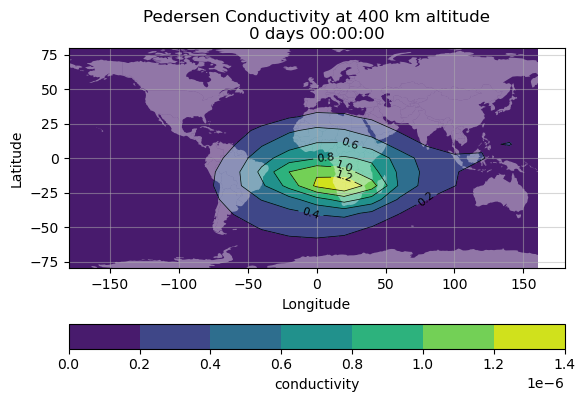

In [221]:
plot_2dgrid(testehall.dropna(),h,'Hall Conductivity at '+ str(h) + " km altitude\n" +time)
plot_2dgrid(testepedersen.dropna(),h,'Pedersen Conductivity at '+str(h)+" km altitude\n"+time)

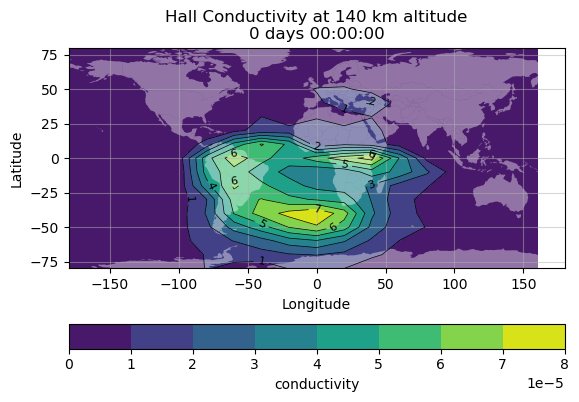

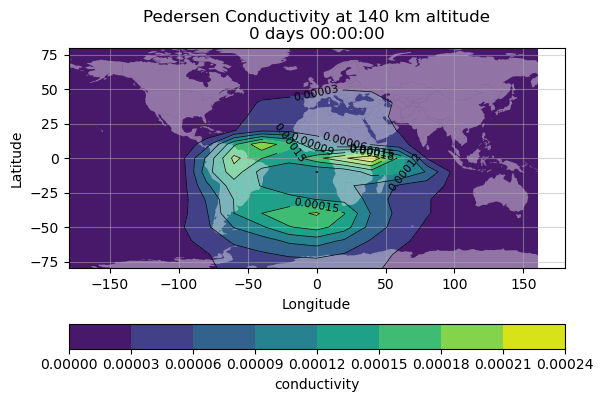

In [231]:
h=140
plot_2dgrid(conductivity.CondH.dropna(),h,'Hall Conductivity at '+str(h)+" km altitude\n"+time)
plot_2dgrid(conductivity.CondP.dropna(),h,'Pedersen Conductivity at '+str(h)+" km altitude\n"+time)

In [100]:
def prepplot_2dgrid_simplified(values,h):    
    X,Y = prepplot_create2Dmeshgrid(values,h)
    value2dformat = prepplot_valueto2Dgrid(values,h)
        
    return X,Y,value2dformat

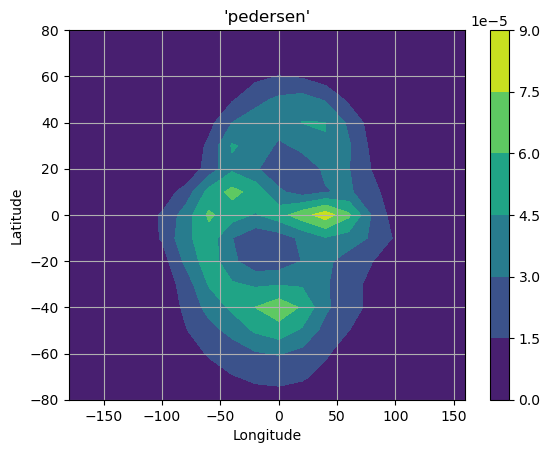

<module 'matplotlib.pyplot' from 'C:\\Users\\tedea\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [101]:
def plot_2dgrid(values,h,title=" "):
    values_plot = values.loc[h].reset_index() #leaving the multindex to use normal indexing
    
    X,Y,value2dformat= prepplot_2dgrid_simplified(values,h)
        
    plt.contourf(X,Y,value2dformat)
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()
    plt.colorbar()   
    
    plt.show()
    return plt
    
plot_2dgrid(conductivity.CondP.dropna(),h,"'pedersen'")

### Perfis

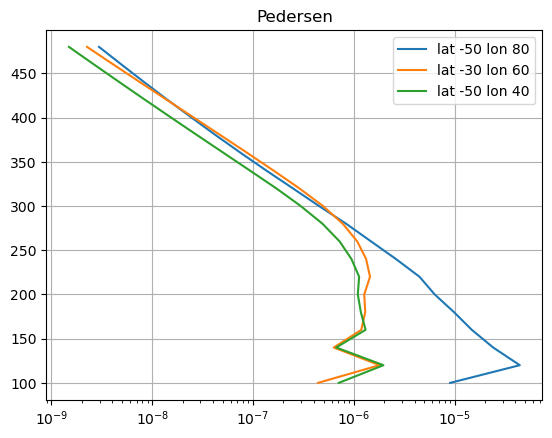

In [103]:
#plotando perfis 
plt.title("Pedersen")
plt.semilogx(testepedersen.loc[:,-50,80],testehall.index.get_level_values('ht').unique(),label='lat -50 lon 80')
plt.plot(testepedersen.loc[:,-30,60],testehall.index.get_level_values('ht').unique(),label='lat -30 lon 60')
plt.plot(testepedersen.loc[:,-50,40],testehall.index.get_level_values('ht').unique(),label='lat -50 lon 40')
plt.grid()
plt.legend()

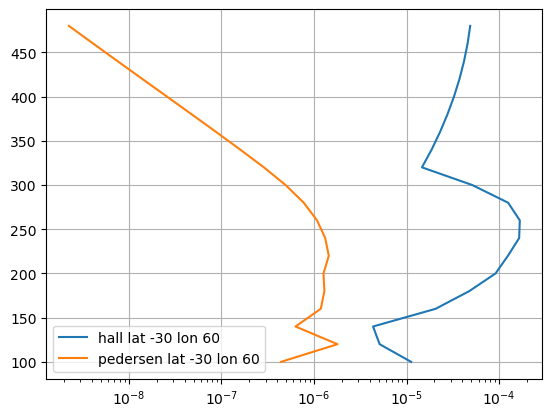

In [145]:
plt.plot(testehall.loc[:,-30,60],testehall.loc[:,:,:].index.get_level_values('ht').unique(),label = 'hall lat -30 lon 60')
plt.semilogx(testepedersen.loc[:,-30,60],testehall.index.get_level_values('ht').unique(),label='pedersen lat -30 lon 60')
plt.grid()
plt.legend()

In [105]:
testepedersen.loc[:,-50,80]

ht
100.0    8.997473e-06
120.0    4.416993e-05
140.0    2.403761e-05
160.0    1.476091e-05
180.0    9.827166e-06
200.0    6.328613e-06
220.0    4.472395e-06
240.0    2.616199e-06
260.0    1.478639e-06
280.0    8.365772e-07
300.0    4.510623e-07
320.0    2.480422e-07
340.0    1.358527e-07
360.0    7.561970e-08
380.0    4.277567e-08
400.0    2.455799e-08
420.0    1.420014e-08
440.0    8.345718e-09
460.0    4.952778e-09
480.0    2.962798e-09
dtype: float64

In [106]:
testehall.loc[:300,:,:].index.get_level_values('lat').unique()[:]

Index([-80.0, -70.0, -60.0, -50.0, -40.0, -30.0, -20.0, -10.0,   0.0,  10.0,
        20.0,  30.0,  40.0,  50.0,  60.0,  70.0,  80.0],
      dtype='float32', name='lat')

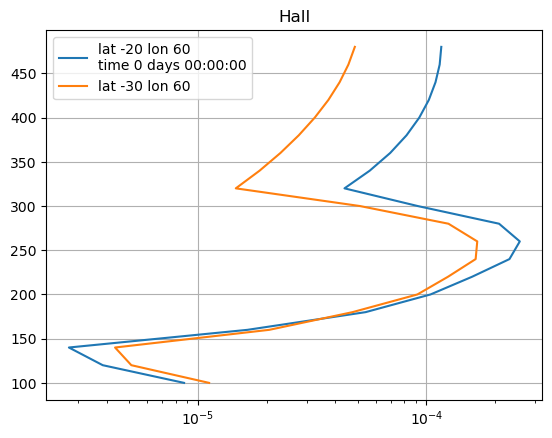

In [107]:
plt.title('Hall')
plt.semilogx(testehall.loc[:,-20,60],testehall.loc[:,:,:].index.get_level_values('ht').unique(),label = 'lat -20 lon 60 \ntime ' + str(time))
plt.plot(testehall.loc[:,-30,60],testehall.loc[:,:,:].index.get_level_values('ht').unique(),label = 'lat -30 lon 60')
#plt.plot(testehall.loc[:,-50,40],testehall.index.get_level_values('ht').unique(),label='lat -50 lon 40')
#plt.plot(testehall.loc[:,-50,100],testehall.index.get_level_values('ht').unique(),label='lat -50 lon 100')

#plt.plot(testehall.loc[:,-40,60],testehall.index.get_level_values('ht').unique(),label='lat -40 lon 60')
#plt.plot(testehall.loc[:,-40,80],testehall.index.get_level_values('ht').unique(),label='lat -40 lon 80')
plt.grid()
plt.legend()

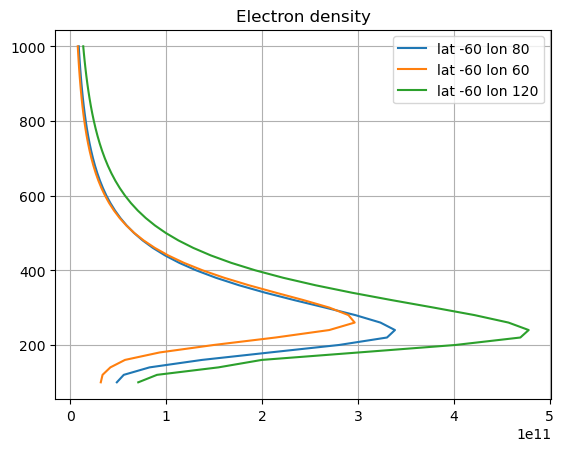

In [108]:
plt.title("Electron density")
plt.plot(ne.loc[:,-60,80],ne.index.get_level_values('ht').unique(),label='lat -60 lon 80')
plt.plot(ne.loc[:,-60,60],ne.index.get_level_values('ht').unique(),label='lat -60 lon 60')
plt.plot(ne.loc[:,-60,120],ne.index.get_level_values('ht').unique(),label='lat -60 lon 120')
plt.legend()
plt.grid()

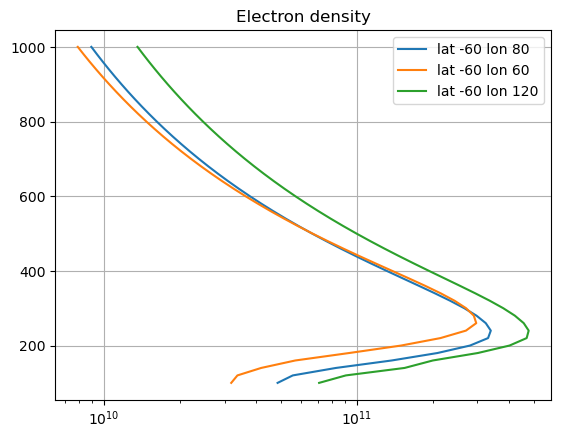

In [109]:
plt.title("Electron density")
plt.semilogx(ne.loc[:,-60,80],ne.index.get_level_values('ht').unique(),label='lat -60 lon 80')
plt.plot(ne.loc[:,-60,60],ne.index.get_level_values('ht').unique(),label='lat -60 lon 60')
plt.plot(ne.loc[:,-60,120],ne.index.get_level_values('ht').unique(),label='lat -60 lon 120')
plt.grid()
plt.legend()

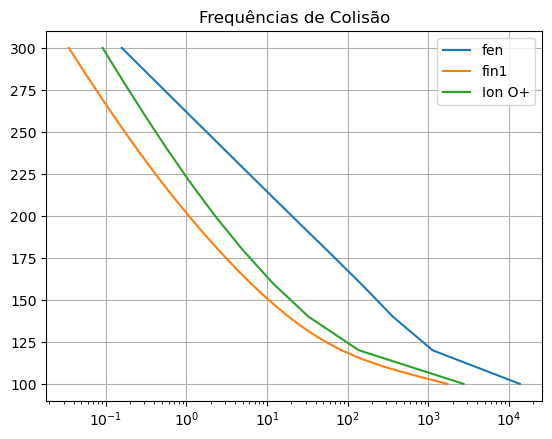

In [147]:
plt.semilogx(freqc.result['fen'].dropna().loc[:300,60,80],
         freqc.result['fen'].dropna().loc[:300,80,80].index.get_level_values('ht').unique(),
        label = "fen")

plt.semilogx(freqc.result['fin1'].dropna().loc[100:300,60,80],
         freqc.result['fin1'].dropna().loc[100:300,60,80].index.get_level_values('ht').unique(),
        label = "fin1")
plt.semilogx(freqc.result['fin2'].dropna().loc[:300,60,80],
         freqc.result['fin2'].dropna().loc[:300,60,80].index.get_level_values('ht').unique(),
        label = "Ion O+")
plt.title("Frequências de Colisão")
plt.legend()
plt.grid()

In [153]:
len(freqc.result['fin1'].dropna().loc[:300,60,80])

61

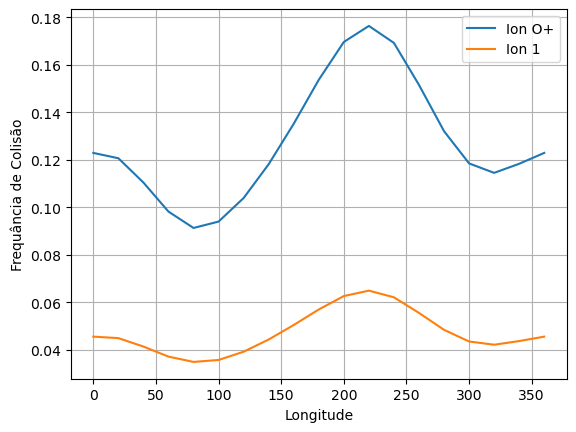

In [155]:
plt.plot(freqc.result['fin2'].dropna().loc[300,60,:].index.get_level_values('lon').unique(),
    freqc.result['fin2'].dropna().loc[300,60,:],         
        label = "Ion O+")
plt.plot(freqc.result['fin1'].dropna().loc[300,60,:].index.get_level_values('lon').unique(),
    freqc.result['fin1'].dropna().loc[300,60,:],         
        label = "Ion 1")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Frequância de Colisão")
plt.grid()

#### Perfil lat

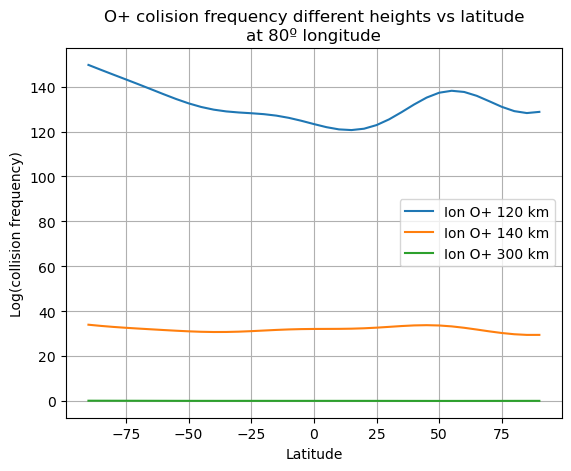

In [158]:
plt.plot(freqc.result['fin2'].dropna().loc[120,:,80].index.get_level_values('lat').unique(),
    freqc.result['fin2'].dropna().loc[120,:,80],         
        label = "Ion O+ 120 km")
plt.plot(freqc.result['fin2'].dropna().loc[140,:,80].index.get_level_values('lat').unique(),
    freqc.result['fin2'].dropna().loc[140,:,80],         
        label = "Ion O+ 140 km")
plt.plot(freqc.result['fin2'].dropna().loc[300,:,80].index.get_level_values('lat').unique(),
    freqc.result['fin2'].dropna().loc[300,:,80],         
        label = "Ion O+ 300 km")
plt.legend()
plt.title("O+ colision frequency different heights vs latitude\nat 80º longitude")

plt.xlabel("Latitude")
plt.ylabel("Log(collision frequency)")
plt.grid()

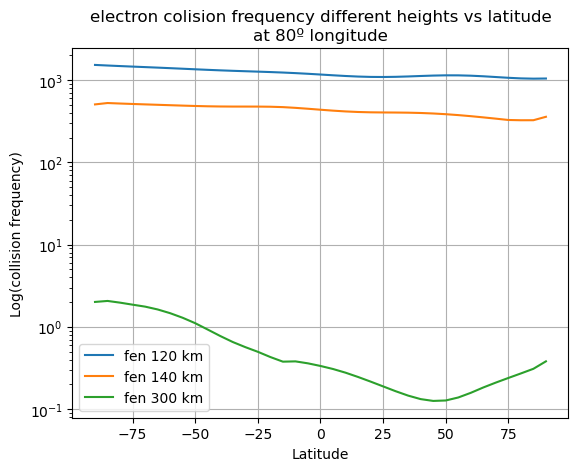

In [160]:
plt.semilogy(freqc.result['fen'].dropna().loc[120,:,80].index.get_level_values('lat').unique(),
    freqc.result['fen'].dropna().loc[120,:,80],         
        label = "fen 120 km")
plt.plot(freqc.result['fen'].dropna().loc[140,:,80].index.get_level_values('lat').unique(),
    freqc.result['fen'].dropna().loc[140,:,80],         
        label = "fen 140 km")
plt.plot(freqc.result['fen'].dropna().loc[300,:,80].index.get_level_values('lat').unique(),
    freqc.result['fen'].dropna().loc[300,:,80],         
        label = "fen 300 km")
plt.legend()
plt.title("electron colision frequency different heights vs latitude\nat 80º longitude")
plt.xlabel("Latitude")
plt.ylabel("Log(collision frequency)")
plt.grid()

In [162]:
lat1 = 60
lon1 = 80
a = np.trapz(testehall.loc[:400,lat1,lon1], testehall.loc[:400,:,:].index.get_level_values('ht').unique())

# Height Integrated Conductivity

In [165]:
#heightintegratedcond = pd.DataFrame([(lat1,lon1,a)],columns=['lat','lon','cond Hall [S]'])
#heightintegratedcond

#### Passar para função

In [168]:
testehall.loc[:,:,:].index.get_level_values('ht').unique().to_list()

[100.0,
 120.0,
 140.0,
 160.0,
 180.0,
 200.0,
 220.0,
 240.0,
 260.0,
 280.0,
 300.0,
 320.0,
 340.0,
 360.0,
 380.0,
 400.0,
 420.0,
 440.0,
 460.0,
 480.0]

In [170]:
import scipy.integrate as scp


In [172]:
# for lon in testehall.loc[:400,:,:].index.get_level_values('lon').unique().to_list():
#     print(lon,np.trapz(testehall.loc[:400,lat,lon],testehall.loc[:400,:,:].index.get_level_values('ht').unique()))
#a = [(lat,lon,np.trapz(testehall.loc[:400,lat,lon],testehall.loc[:400,:,:].index.get_level_values('ht').unique())) for lon in testehall.loc[:400,:,:].index.get_level_values('lon').unique().to_list()]

#creating dataframe with values of height integrated conductivity in a matrix
a = [] #list to be filled with height intratade values. cada linha é numa latitude específica e coluna uma longitude
for lat in testehall.loc[:400,:,:].index.get_level_values('lat').unique().to_list():
    a.append( [(np.trapz(testehall.loc[:400,lat,lon],testehall.loc[:400,:,:].index.get_level_values('ht').unique())) for lon in testehall.loc[:400,:,:].index.get_level_values('lon').unique().to_list()])

heightintegratedcond = pd.DataFrame(a, index= testehall.loc[:400,:,:].index.get_level_values('lat').unique().to_list(),columns= testehall.loc[:400,:,:].index.get_level_values('lon').unique().to_list())

In [174]:
def calc_height_integrtated_conductivity(values,h=480):
    a = [] #list to be filled with height intratade values. cada linha é numa latitude específica e coluna uma longitude
    #h = 500
    for lat in values.loc[:h,:,:].index.get_level_values('lat').unique().to_list():
        a.append( [(np.trapz(values.loc[:h,lat,lon],values.loc[:h,:,:].index.get_level_values('ht').unique())) for lon in values.loc[:h,:,:].index.get_level_values('lon').unique().to_list()])
    
    heightintegratedcond = pd.DataFrame(a, index= values.loc[:h,:,:].index.get_level_values('lat').unique().to_list(),columns= values.loc[:h,:,:].index.get_level_values('lon').unique().to_list())
    return heightintegratedcond 

In [176]:
def calc_height_integrtated_conductivity2(values,h=480):
    a = [] #list to be filled with height intratade values. cada linha é numa latitude específica e coluna uma longitude
    #h = 500
    for lat in values.loc[:h,:,:].index.get_level_values('lat').unique().to_list():
        a.append( [(scp.trapz(values.loc[:h,lat,lon],values.loc[:h,:,:].index.get_level_values('ht').unique())) for lon in values.loc[:h,:,:].index.get_level_values('lon').unique().to_list()])
    
    heightintegratedcond = pd.DataFrame(a, index= values.loc[:h,:,:].index.get_level_values('lat').unique().to_list(),columns= values.loc[:h,:,:].index.get_level_values('lon').unique().to_list())
    return heightintegratedcond 

In [178]:
heightintegratedcond3 = calc_height_integrtated_conductivity2(conductivity.CondH.dropna(),h=480)
heightintegratedcond3

0.0       20.0      40.0      60.0      80.0      100.0     120.0  \
-80.0  0.001694  0.002545  0.002000  0.002828  0.002298  0.003513  0.003541   
-70.0  0.001862  0.002123  0.002045  0.001878  0.002216  0.004561  0.004850   
-60.0  0.002871  0.002248  0.001722  0.002045  0.003180  0.005493  0.007043   
-50.0  0.006035  0.003915  0.002180  0.001852  0.003635  0.007470  0.009920   
-40.0  0.012485  0.007088  0.003841  0.002487  0.004246  0.010629  0.015091   
-30.0  0.024362  0.012901  0.008076  0.005469  0.006972  0.014514  0.022598   
-20.0  0.045199  0.027910  0.021473  0.014718  0.012780  0.020875  0.033366   
-10.0  0.086787  0.070964  0.051102  0.026356  0.016689  0.022066  0.038992   
 0.0   0.129937  0.098752  0.054423  0.023699  0.013145  0.020410  0.038996   
 10.0  0.113851  0.100657  0.061669  0.022367  0.011203  0.016464  0.031713   
 20.0  0.166503  0.099866  0.039379  0.011953  0.007068  0.011820  0.021675   
 30.0  0.070105  0.043408  0.020904  0.007697  0.004011  0.005575  0.008705   
 40.0  0.025556  0.019946  0.012566  0.005620  0.002756  0.002811  0.003544   
 50.0  0.012917  0.011262  0.007779  0.003907  0.001983  0.001777  0.002459   
 60.0  0.008600  0.007490  0.005255  0.002954  0.001645  0.001354  0.001671   
 70.0  0.005606  0.004920  0.003691  0.002427  0.001568  0.001222  0.001309   
 80.0  0.003211  0.003012  0.002577  0.002054  0.001602  0.001308  0.001183   

          140.0     160.0     180.0     200.0     220.0     240.0     260.0  \
-80.0  0.003697  0.004063  0.004124  0.003921  0.003513  0.003265  0.003184   
-70.0  0.005557  0.006809  0.006993  0.006485  0.004934  0.003969  0.003045   
-60.0  0.009144  0.010716  0.011219  0.009907  0.007319  0.004863  0.003329   
-50.0  0.013633  0.015471  0.016244  0.014235  0.009766  0.005595  0.004765   
-40.0  0.019063  0.020209  0.020982  0.019476  0.013989  0.008285  0.005701   
-30.0  0.027351  0.028803  0.031279  0.032428  0.026456  0.016740  0.013742   
-20.0  0.041625  0.050962  0.060701  0.061266  0.048579  0.031299  0.024206   
-10.0  0.055533  0.070082  0.073385  0.063176  0.052229  0.038149  0.031276   
 0.0   0.056352  0.062828  0.065526  0.061148  0.054040  0.037776  0.029966   
 10.0  0.047955  0.054091  0.050016  0.044840  0.035695  0.022829  0.017871   
 20.0  0.030671  0.035189  0.034798  0.029692  0.022187  0.015485  0.012242   
 30.0  0.011338  0.016345  0.016988  0.014703  0.010245  0.009523  0.009898   
 40.0  0.006280  0.005731  0.006374  0.006188  0.006737  0.006923  0.007204   
 50.0  0.003184  0.004218  0.004566  0.003480  0.005122  0.004311  0.005869   
 60.0  0.002731  0.001074  0.003213  0.004084  0.003866  0.004086  0.005141   
 70.0  0.001499  0.001975  0.002231  0.002449  0.002817  0.003460  0.003688   
 80.0  0.001195  0.001220  0.001366  0.001527  0.001791  0.001937  0.002092   

          280.0     300.0     320.0     340.0  
-80.0  0.002684  0.001517  0.001583  0.001865  
-70.0  0.003078  0.001289  0.001583  0.001608  
-60.0  0.002029  0.002021  0.002536  0.003057  
-50.0  0.003407  0.004353  0.006054  0.007060  
-40.0  0.006502  0.009068  0.014093  0.016543  
-30.0  0.015530  0.021195  0.029410  0.034278  
-20.0  0.028632  0.041136  0.053900  0.059185  
-10.0  0.033920  0.042819  0.084384  0.095224  
 0.0   0.037107  0.072375  0.076883  0.134224  
 10.0  0.024728  0.066270  0.146190  0.118408  
 20.0  0.018550  0.041177  0.118951  0.195292  
 30.0  0.014641  0.025795  0.050697  0.079143  
 40.0  0.010963  0.016722  0.024159  0.028627  
 50.0  0.008299  0.011234  0.013617  0.013967  
 60.0  0.006181  0.007363  0.008329  0.008741  
 70.0  0.004014  0.004512  0.005106  0.005586  
 80.0  0.002302  0.002573  0.002882  0.003139

In [179]:
#conductivity.CondH.dropna()

In [182]:
#print(heightintegratedcond3,'\n\n\n\n =========================== height out of function =======================\n',heightintegratedcond)

In [184]:
#testehall

In [186]:
# heightintegratedcond1 = heightintegratedcond
# for lon in testehall.loc[:400,:,:].index.get_level_values('lon').unique().to_list():
#     heightintegratedcond1  = heightintegratedcond1._append( pd.DataFrame([(lat,lon,np.trapz(testehall.loc[:400,lat,lon],
#                                                                                            testehall.loc[:400,:,:].index.get_level_values('ht').unique()))
#                                                                          for lat in testehall.loc[:400,:,:].index.get_level_values('lat').unique().to_list()]), ignore_index=True)

In [188]:
#testehall.loc[:400,:,:].index.get_level_values('lat').unique().to_list()

In [190]:
# heightintegratedcond2 = heightintegratedcond
# for lon in testehall.loc[:400,:,:].index.get_level_values('lon').unique().to_list():
#     heightintegratedcond2 = heightintegratedcond2._append(
#         pd.DataFrame([(lat,lon,np.trapz(testehall.loc[:400,lat,lon],testehall.loc[:400,:,:].index.get_level_values('ht').unique())) for lat in testehall.loc[:400,:,:].index.get_level_values('lat').unique().to_list()]), ignore_index=True)
#     heightintegratedcond2

In [192]:
#values_plot

In [194]:
values_plot = heightintegratedcond3
X,Y = np.meshgrid(values_plot.columns - 180,values_plot.index)

In [196]:
#print(X,"\n\n\n",Y)

In [198]:
#print(X,"\n\n\n",Y)

In [200]:
def plot_2dgrid_hintegrated(value2dformat,X,Y,h,title=" "):
    plt.contourf(X,Y,value2dformat)
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()
    plt.colorbar()   
    
    plt.show()
    return plt    

def plot_2dgrid_hintegrated2(value2dformat,X,Y,h,title=" ",sizefig=(10,15)):
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    
    fig, ax = plt.subplots()
    cntr = ax.contourf(X,Y,value2dformat,cmap = 'jet')
    contour = ax.contour(X,Y,value2dformat,colors = 'black', linewidths=0.5)
    ax.clabel(contour, inline = True, fontsize = 8)

    countries.plot(ax=ax,color = "white",figsize=sizefig, alpha = 0.2)
    
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim([-180, 160])
    ax.set_ylim([-80,80])
    ax.grid(visible = True, alpha = 0.5)
    
    fig.colorbar(cntr, ax = ax, label = 'Conductivity [S]',location = 'bottom')
    fig.savefig("plot_" + title +'.png', dpi = 300, transparent=True)
    plt.show()

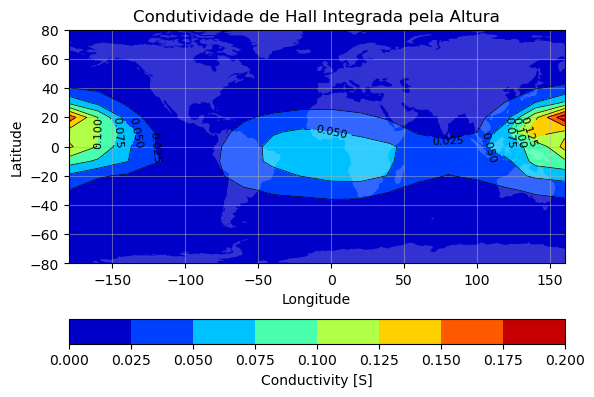

In [235]:
h = 120
plot_2dgrid_hintegrated2(values_plot,X,Y,h,title="Condutividade de Hall Integrada pela Altura")

In [203]:
testehall.loc[:400,lat,:]

ht     lat   lon  
100.0  80.0  0.0      0.000005
             20.0     0.000005
             40.0     0.000005
             60.0     0.000005
             80.0     0.000005
                        ...   
400.0  80.0  260.0    0.000012
             280.0    0.000013
             300.0    0.000015
             320.0    0.000017
             340.0    0.000018
Length: 288, dtype: float64

In [204]:
conductivity.CondH.dropna().to_csv("CondH_6h" + ".csv",sep=",",header=True)

In [205]:
conductivity.CondP.dropna().to_csv("CondP_6h" + ".csv",sep=",",header=True)

In [210]:
heightintegratedcondP3 = calc_height_integrtated_conductivity2(conductivity.CondP.dropna(),h=500)
values_plot_pedersen = heightintegratedcondP3
Xp,Yp = np.meshgrid(values_plot_pedersen.columns - 180,values_plot.index)

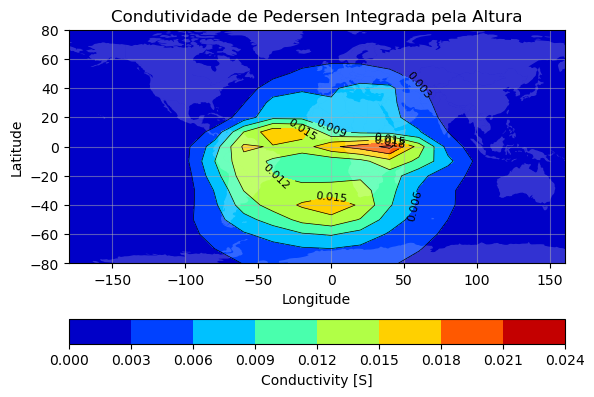

In [212]:
plot_2dgrid_hintegrated2(values_plot_pedersen,Xp,Yp,h,title="Condutividade de Pedersen Integrada pela Altura")